# quarkml 功能介绍
```
适用于风控算法领域，集 特征处理，特征工程，模型训练， 树模型分布式训练等功能于一体的自动化工具
主要功能：
    1. 特征工程
       a. 特征处理，分类特征转换数值index，空值填充，异常值去除, 数据压缩，特征分析报告打印
       b. 特征衍生，基于内置的算子进行自动衍生，并基于booster方法进行筛选海量衍生特征
       c. 特征指标，对特征进行指标计算【iv，psi】
    2. 模型工程
       a. 模型交叉验证，用于验证模型性能
       b. 模型超参
       c. 模型训练，提供树模型多进程训练，分布式训练，常规训练
       d. 模型解释性，自动化产生shap 模型解释图
       e. 预估加速，对于常规进行joblib保存的模型进行编译，生成编译文件，然后利用load_model，predict进行预估
    3. 分布式工程
       a. 分布式训练lightgbm
       b. 分布式数据处理
```

## quarkml 包的功能代码演示

### 项目开始导入相关包

In [1]:
import ray
import pandas as pd
import shap
from quarkml.engineering import Engine

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-31 17:16:42,075	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/opt/conda/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecatio

### 创建工具处理类

In [2]:
engine = Engine()

### 功能一，特征处理 使用FE工具的 data_processing_fit 方法
```
1. 划分数据集中的类别特征和数值特征
   其中会根据数据中数值特征的唯一值总量进行判断，若总量小于ordinal_number（可配置参数），会划入类别特征
2. 缺失值填充
   对类别特征的填充采用数据中的众数，对数值特征的填充采用数据中的均值
   会保留每个特征的填充逻辑，方便后续新数据复用
3. 异常值删除
   检测异常的方法一：均方差
   在统计学中，如果一个数据分布近似正态，
   那么大约 68% 的数据值会在均值的一个标准差范围内，
   大约 95% 会在两个标准差范围内，
   大约 99.7% 会在三个标准差范围内。
   这里采用3个标准差以外的进行去除

4. 对离散特征进行数值化，tokenizer
   对每列特征进行转换index, [男， 女] -> [0, 1] 并保留{男: 0, 女: 1}
   会保留每个特征的tokenizer逻辑，方便后续新数据复用

5. 展示数据中的每个 feature-label 分布
   会展示数据的基础信息和基本描述
   会有每个特征与目标的分布，保存图到本地
   会给出整数据的详细分析报告，保存为html形式，可直接打开查看

6. 对数据进行压缩
   对数据中的数值化数据进行分析，判断数据的中最大最小范围，然后对数据采用合理的数据类型【int64-int32-int16-float64-float32-float16】等
```


#### data_processing_fit 介绍
```python
data_processing_fit(
  ds: str | pd.DataFrame,
  label: str,
  cat_feature: List = [],
  num_feature: List = [],
  ordinal_number=100,
  is_fillna=False,
  drop_outliers=False,
  is_token=True,
  verbosity=False,
  compress=False,
  report_dir="./encode",
)
ds: str | pd.DataFrame, 原始数据 （必选项）, 若传入文件路径，则返回处理后的新文件路径（处理后的数据文件）， 若传入DataFrame，则返回新的DataFrame
label: str,  原始数据的label （必选项）
cat_feature: list = [], 指定类别特征， （非选项）， 若为空，则会利用上述【功能1】获得
num_feature: list = [], 指定连续特征， （非选项）， 若为空，则会利用上述【功能1】获得
ordinal_number=100, 指定数值特征若唯一值总数小于ordinal_number，则会划分成类别特征，用于【功能1】， （非选项）， 若为空，默认 100
is_fillna=False, 是否自动缺失值填充【功能2】，连续值填充众数，离散值填充均值
drop_outliers=False, 是否异常值删除【功能3】
is_token=True, 是否数值化【功能4】
verbosity=False, 是否展示分析报告【功能5】
compress=False, 是否对数据进行压缩【功能6】
report_dir="./encode", 上述功能产生的中间结果都会落到该文件夹内
```

In [3]:
# 数据处理
ds = pd.read_csv("credit.csv")
print("处理前：", ds.head(5))
ds, cat, con = engine.feature_processing(ds, 'class')
print("处理后：",ds.head(5))

2023-10-31 17:17:39.709 | INFO     | quarkml.engineering:feature_processing:63 - *************** [data_processing_fit] cost time: 0.015624284744262695 ***************


处理前：    german_credit  checking_status                          duration  \
0           '<0'                6  'critical/other existing credit'   
1     '0<=X<200'               48                   'existing paid'   
2  'no checking'               12  'critical/other existing credit'   
3           '<0'               42                   'existing paid'   
4           '<0'               24              'delayed previously'   

        credit_history  purpose         credit_real credit_amount  employment  \
0             radio/tv     1169  'no known savings'         '>=7'           4   
1             radio/tv     5951              '<100'      '1<=X<4'           2   
2            education     2096              '<100'      '4<=X<7'           2   
3  furniture/equipment     7882              '<100'      '4<=X<7'           2   
4            'new car'     4870              '<100'      '1<=X<4'           3   

  installment_commitment personal_status  ...      residence_since  \
0          

### 功能二，特征衍生 使用FE工具中 feature_generation 方法
1. 对给予数据进行特征衍生，产生大量的候选特征集
2. 对衍生后的候选特征集进行筛选，获得最终对效果指标有意义的特征集

#### feature_generation 方法介绍
```python
feature_generation(
   ds: str | pd.DataFrame,
   label: str,
   cat_features: List = None,
   is_filter=True,
   params=None,
   select_method='predictive',
   min_candidate_features=200,
   blocks=5,
   ratio=0.5,
   distributed_and_multiprocess=-1,
   report_dir="encode",
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 若传入文件路径，则返回处理后的新文件路径（处理后的数据文件）， 若传入DataFrame，则返回新的DataFrame
label: str,  原始数据的label （必选项）
cat_features: list = None, 指定类别特征， （非选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
is_filter: 是否对衍生后的特征进行筛选，由于衍生的特征数巨大，所以默认为True
params: 特征筛选过程中树模型的参数（非选项）， 若为空，有默认参数
select_method: 筛选的评估指标，predictive -> 提升收益，corr 为与目标的相关度
min_candidate_features: 最小候选特征，若每个block后，候选特征小于最小候选特征，就停止block了
blocks： 主要是用于booster 中对数据进行增量式划分成多个数据块
ratio：主要是用于booster 中candidate_features被淘汰ratio=0.5 一半了就，可以直接全量数据进行淘汰了，数据量越大，该值应该设置越小一般在0.2 ~ 0.5
distributed_and_multiprocess=-1， 三种运行模式【常规 -1，多进程 2，分布式 1】
report_dir="./encode", 中间结果存储
```

In [6]:
# 特征衍生
ds = engine.feature_generation(ds, 'class', cat, is_filter=True)

2023-10-31 17:21:00.935 | INFO     | quarkml.generator.baisc_operation:fit:56 - ===== 【categorical_features】: ['age', 'credit_amount', 'credit_history', 'credit_real', 'duration', 'existing_credits', 'german_credit', 'installment_commitment', 'num_dependents', 'other_payment_plans', 'own_telephone', 'personal_status', 'residence_since'] =====
2023-10-31 17:21:00.936 | INFO     | quarkml.generator.baisc_operation:fit:57 - ===== 【numerical_features】: ['checking_status', 'employment', 'housing', 'job', 'other_parties', 'property_magnitude', 'purpose'] =====
2023-10-31 17:21:00.956 | INFO     | quarkml.generator.feature_generation:basic_generation:86 - ===== candidate_features number: 1053 =====
2023-10-31 17:21:01.896 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_l

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.921574	valid_1's auc: 0.79205
[200]	training's auc: 0.959853	valid_1's auc: 0.784321
Early stopping, best iteration is:
[35]	training's auc: 0.871763	valid_1's auc: 0.801129


2023-10-31 17:21:02.599 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.7065708637237549 ************************************
2023-10-31 17:21:02.609 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.926661	valid_1's auc: 0.792078
[200]	training's auc: 0.962784	valid_1's auc: 0.806422
[300]	training's auc: 0.979096	valid_1's auc: 0.800105
Early stopping, best iteration is:
[198]	training's auc: 0.96188	valid_1's auc: 0.808659


2023-10-31 17:21:03.365 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.7586629390716553 ************************************
2023-10-31 17:21:03.376 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.936206	valid_1's auc: 0.805067
[200]	training's auc: 0.96905	valid_1's auc: 0.786813
Early stopping, best iteration is:
[50]	training's auc: 0.893411	valid_1's auc: 0.832282


2023-10-31 17:21:04.041 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.6681807041168213 ************************************
2023-10-31 17:21:04.052 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.927054	valid_1's auc: 0.78892
[200]	training's auc: 0.961856	valid_1's auc: 0.787985
[300]	training's auc: 0.977108	valid_1's auc: 0.793829
[400]	training's auc: 0.984337	valid_1's auc: 0.788336
[500]	training's auc: 0.99049	valid_1's auc: 0.789504
Early stopping, best iteration is:
[309]	training's auc: 0.977586	valid_1's auc: 0.795348


2023-10-31 17:21:04.844 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.7960398197174072 ************************************
2023-10-31 17:21:04.857 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.930712	valid_1's auc: 0.774502
[200]	training's auc: 0.965289	valid_1's auc: 0.768133
Early stopping, best iteration is:
[74]	training's auc: 0.911217	valid_1's auc: 0.795023


2023-10-31 17:21:05.547 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.6951298713684082 ************************************
2023-10-31 17:21:05.660 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:05.689 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.028981924057006836 ************************************
2023-10-31 17:21:05.691 | INFO     | quarkml.model

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800489	valid_1's auc: 0.74026
[200]	training's auc: 0.800489	valid_1's auc: 0.74026
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:05.957 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:05.997 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04065203666687012 ************************************
2023-10-31 17:21:06.000 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796471	valid_1's auc: 0.770563
Early stopping, best iteration is:
[71]	training's auc: 0.794375	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794549	valid_1's auc: 0.753247
[200]	training's auc: 0.794025	valid_1's auc: 0.753247
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234


2023-10-31 17:21:06.183 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.036309242248535156 ************************************
2023-10-31 17:21:06.186 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:06.204 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.018338918685913086 ************************************
2023-10-31 17:21:06.206 | INFO     | quarkml.gene

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.794899	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:06.442 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:06.481 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03844857215881348 ************************************
2023-10-31 17:21:06.483 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795423	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:06.676 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05083632469177246 ************************************
2023-10-31 17:21:06.678 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:06.724 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04628419876098633 ************************************
2023-10-31 17:21:06.729 | INFO     | quarkml.genera

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794549	valid_1's auc: 0.766234
[200]	training's auc: 0.794549	valid_1's auc: 0.766234
Early stopping, best iteration is:
[46]	training's auc: 0.795772	valid_1's auc: 0.78355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's auc: 0.795947	valid_1's auc: 0.779221


2023-10-31 17:21:06.912 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03937888145446777 ************************************
2023-10-31 17:21:06.913 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 8 end ************************************
2023-10-31 17:21:07.017 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:07.057 | INFO     | quarkml.model.tree_

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.80573	valid_1's auc: 0.727273
[200]	training's auc: 0.807128	valid_1's auc: 0.731602
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:07.254 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05180716514587402 ************************************
2023-10-31 17:21:07.255 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:07.325 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.06953001022338867 ************************************
2023-10-31 17:21:07.326 | INFO     | quarkml.genera

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796646	valid_1's auc: 0.735931
[200]	training's auc: 0.79717	valid_1's auc: 0.722944
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:07.471 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.01967024803161621 ************************************
2023-10-31 17:21:07.472 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 11 end ************************************
2023-10-31 17:21:07.565 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:07.593 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.811495	valid_1's auc: 0.779221
[200]	training's auc: 0.811495	valid_1's auc: 0.779221
Early stopping, best iteration is:
[31]	training's auc: 0.807477	valid_1's auc: 0.792208
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	training's auc: 0.807477	valid_1's auc: 0.792208
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:07.859 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:07.896 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0365140438079834 ************************************
2023-10-31 17:21:07.897 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799616	valid_1's auc: 0.753247
[200]	training's auc: 0.799616	valid_1's auc: 0.753247
Early stopping, best iteration is:
[3]	training's auc: 0.796122	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.796122	valid_1's auc: 0.766234


2023-10-31 17:21:08.084 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02672123908996582 ************************************
2023-10-31 17:21:08.084 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 15 end ************************************
2023-10-31 17:21:08.176 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:08.202 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798917	valid_1's auc: 0.766234
[200]	training's auc: 0.799266	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795597	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795597	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.797345	valid_1's auc: 0.766234
[200]	training's auc: 0.797694	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:08.382 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.023937702178955078 ************************************
2023-10-31 17:21:08.383 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 17 end ************************************
2023-10-31 17:21:08.475 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:08.504 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795597	valid_1's auc: 0.761905
[200]	training's auc: 0.797519	valid_1's auc: 0.761905
Early stopping, best iteration is:
[47]	training's auc: 0.795772	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794375	valid_1's auc: 0.766234
[200]	training's auc: 0.794375	valid_1's auc: 0.766234
Early stopping, best iteration is:
[79]	training's auc: 0.794025	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:08.766 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:08.867 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.10055160522460938 ************************************
2023-10-31 17:21:08.869 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:08.970 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.10188627243041992 ************************************
2023-10-31 17:21:08.972 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 20 end ************************************
2023-10-31 17:21:09.071 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:09.175 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.840846	valid_1's auc: 0.701299
[200]	training's auc: 0.840846	valid_1's auc: 0.705628
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905


2023-10-31 17:21:09.363 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:09.452 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.08861565589904785 ************************************
2023-10-31 17:21:09.454 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794899	valid_1's auc: 0.766234
[200]	training's auc: 0.795073	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234


2023-10-31 17:21:09.643 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:09.749 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.1064906120300293 ************************************
2023-10-31 17:21:09.751 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.840846	valid_1's auc: 0.701299
[200]	training's auc: 0.840846	valid_1's auc: 0.705628
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905


2023-10-31 17:21:09.850 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 23 end ************************************
2023-10-31 17:21:09.947 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:10.025 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.07759690284729004 ************************************
2023-10-31 17:21:10.027 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.806429	valid_1's auc: 0.770563
[200]	training's auc: 0.810273	valid_1's auc: 0.770563
Early stopping, best iteration is:
[35]	training's auc: 0.805556	valid_1's auc: 0.78355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.796296	valid_1's auc: 0.770563


2023-10-31 17:21:10.178 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02793121337890625 ************************************
2023-10-31 17:21:10.179 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:10.201 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.021352529525756836 ************************************
2023-10-31 17:21:10.202 | INFO     | quarkml.gener

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798393	valid_1's auc: 0.753247
[200]	training's auc: 0.798043	valid_1's auc: 0.748918
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:10.361 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.029852867126464844 ************************************
2023-10-31 17:21:10.365 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 26 end ************************************
2023-10-31 17:21:10.462 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:10.490 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.797345	valid_1's auc: 0.753247
[200]	training's auc: 0.798218	valid_1's auc: 0.753247
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:10.681 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.031285762786865234 ************************************
2023-10-31 17:21:10.681 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 28 end ************************************
2023-10-31 17:21:10.775 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:10.810 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.801188	valid_1's auc: 0.735931
[200]	training's auc: 0.801188	valid_1's auc: 0.735931
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234


2023-10-31 17:21:10.992 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.031115055084228516 ************************************
2023-10-31 17:21:10.993 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 30 end ************************************
2023-10-31 17:21:11.093 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:11.137 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798567	valid_1's auc: 0.748918
[200]	training's auc: 0.798567	valid_1's auc: 0.748918
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798742	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.770563
[300]	training's auc: 0.796646	valid_1's auc: 0.770563
Early stopping, best iteration is:
[131]	training's auc: 0.79717	valid_1's auc: 0.770563


2023-10-31 17:21:11.311 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05827784538269043 ************************************
2023-10-31 17:21:11.313 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:11.335 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.021782875061035156 ************************************
2023-10-31 17:21:11.336 | INFO     | quarkml.gener

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	training's auc: 0.796122	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796471	valid_1's auc: 0.770563
[200]	training's auc: 0.798218	valid_1's auc: 0.757576
Early stopping, best iteration is:
[28]	training's auc: 0.795248	valid_1's auc: 0.787879
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.795248	valid_1's auc: 0.787879


2023-10-31 17:21:11.604 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:11.643 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.039217233657836914 ************************************
2023-10-31 17:21:11.646 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.824598	valid_1's auc: 0.792208
[200]	training's auc: 0.824598	valid_1's auc: 0.792208
Early stopping, best iteration is:
[18]	training's auc: 0.808351	valid_1's auc: 0.822511
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.808351	valid_1's auc: 0.822511
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:11.810 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.01869034767150879 ************************************
2023-10-31 17:21:11.810 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 35 end ************************************
2023-10-31 17:21:11.908 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:11.940 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.819706	valid_1's auc: 0.714286
[200]	training's auc: 0.819706	valid_1's auc: 0.714286
Early stopping, best iteration is:
[2]	training's auc: 0.80014	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.80014	valid_1's auc: 0.770563


2023-10-31 17:21:12.207 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:12.242 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03455185890197754 ************************************
2023-10-31 17:21:12.243 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794375	valid_1's auc: 0.770563
[200]	training's auc: 0.794724	valid_1's auc: 0.774892
[300]	training's auc: 0.794549	valid_1's auc: 0.774892
Early stopping, best iteration is:
[142]	training's auc: 0.794724	valid_1's auc: 0.774892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800489	valid_1's auc: 0.735931
[200]	training's auc: 0.801013	valid_1's auc: 0.735931
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:12.500 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:12.526 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02642059326171875 ************************************
2023-10-31 17:21:12.528 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:12.776 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:12.807 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.030816316604614258 ************************************
2023-10-31 17:21:12.808 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800839	valid_1's auc: 0.757576
[200]	training's auc: 0.801363	valid_1's auc: 0.770563
Early stopping, best iteration is:
[69]	training's auc: 0.802586	valid_1's auc: 0.774892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.797694	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795597	valid_1's auc: 0.766234
[200]	training's auc: 0.795597	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:13.070 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:13.119 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.049035072326660156 ************************************
2023-10-31 17:21:13.122 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.810098	valid_1's auc: 0.770563
[200]	training's auc: 0.810971	valid_1's auc: 0.774892
[300]	training's auc: 0.81202	valid_1's auc: 0.787879
[400]	training's auc: 0.81202	valid_1's auc: 0.787879
Early stopping, best iteration is:
[252]	training's auc: 0.81167	valid_1's auc: 0.787879
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.803634	valid_1's auc: 0.78355
[200]	training's auc: 0.803634	valid_1's auc: 0.78355
Early stopping, best iteration is:
[9]	training's auc: 0.801363	valid_1's auc: 0.78355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[9]	training's auc: 0.801363	valid_1's auc: 0.78355


2023-10-31 17:21:13.296 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.030515432357788086 ************************************
2023-10-31 17:21:13.297 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 45 end ************************************
2023-10-31 17:21:13.384 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:13.426 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.843816	valid_1's auc: 0.701299
[200]	training's auc: 0.842243	valid_1's auc: 0.701299
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.761905


2023-10-31 17:21:13.602 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.039114952087402344 ************************************
2023-10-31 17:21:13.604 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:13.636 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03179645538330078 ************************************
2023-10-31 17:21:13.636 | INFO     | quarkml.gener

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.761905
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.761905
[200]	training's auc: 0.796471	valid_1's auc: 0.761905
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:13.899 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:13.940 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04136085510253906 ************************************
2023-10-31 17:21:13.942 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.81499	valid_1's auc: 0.709957
[200]	training's auc: 0.817086	valid_1's auc: 0.705628
Early stopping, best iteration is:
[1]	training's auc: 0.797869	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.797869	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.836827	valid_1's auc: 0.766234
[200]	training's auc: 0.836827	valid_1's auc: 0.766234
Early stopping, best iteration is:
[12]	training's auc: 0.81464	valid_1's auc: 0.78355


2023-10-31 17:21:14.107 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04083538055419922 ************************************
2023-10-31 17:21:14.109 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:14.141 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03168988227844238 ************************************
2023-10-31 17:21:14.144 | INFO     | quarkml.genera

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.81464	valid_1's auc: 0.78355
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:14.324 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.030913591384887695 ************************************
2023-10-31 17:21:14.324 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 51 end ************************************
2023-10-31 17:21:14.422 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:14.469 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.805556	valid_1's auc: 0.748918
[200]	training's auc: 0.80608	valid_1's auc: 0.735931
Early stopping, best iteration is:
[1]	training's auc: 0.796122	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.796122	valid_1's auc: 0.766234


2023-10-31 17:21:14.669 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04316139221191406 ************************************
2023-10-31 17:21:14.672 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:14.702 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.029551029205322266 ************************************
2023-10-31 17:21:14.703 | INFO     | quarkml.gener

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794549	valid_1's auc: 0.766234
[200]	training's auc: 0.794549	valid_1's auc: 0.766234
Early stopping, best iteration is:
[46]	training's auc: 0.795772	valid_1's auc: 0.78355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's auc: 0.795947	valid_1's auc: 0.779221
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796122	valid_1's auc: 0.757576


2023-10-31 17:21:14.872 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.053740739822387695 ************************************
2023-10-31 17:21:14.876 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:14.909 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03292536735534668 ************************************
2023-10-31 17:21:14.910 | INFO     | quarkml.gener

[200]	training's auc: 0.798218	valid_1's auc: 0.757576
Early stopping, best iteration is:
[71]	training's auc: 0.795772	valid_1's auc: 0.774892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:15.057 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.045259714126586914 ************************************
2023-10-31 17:21:15.061 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:15.089 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02811408042907715 ************************************
2023-10-31 17:21:15.091 | INFO     | quarkml.gener

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.815514	valid_1's auc: 0.69697
[200]	training's auc: 0.819182	valid_1's auc: 0.683983
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.766234


2023-10-31 17:21:15.272 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03265523910522461 ************************************
2023-10-31 17:21:15.272 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 56 end ************************************
2023-10-31 17:21:15.374 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:15.416 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.813767	valid_1's auc: 0.757576
[200]	training's auc: 0.813242	valid_1's auc: 0.761905
Early stopping, best iteration is:
[8]	training's auc: 0.799266	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.799266	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795772	valid_1's auc: 0.757576


2023-10-31 17:21:15.615 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04712343215942383 ************************************
2023-10-31 17:21:15.618 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:15.647 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.029100656509399414 ************************************
2023-10-31 17:21:15.647 | INFO     | quarkml.gener

[200]	training's auc: 0.795772	valid_1's auc: 0.757576
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:15.784 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03568673133850098 ************************************
2023-10-31 17:21:15.786 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:15.820 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0337071418762207 ************************************
2023-10-31 17:21:15.821 | INFO     | quarkml.generat

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.842593	valid_1's auc: 0.718615
[200]	training's auc: 0.843117	valid_1's auc: 0.714286
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.761905


2023-10-31 17:21:16.010 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.04691576957702637 ************************************
2023-10-31 17:21:16.012 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 60 end ************************************
2023-10-31 17:21:16.114 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:16.151 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.779221
[200]	training's auc: 0.796122	valid_1's auc: 0.779221
Early stopping, best iteration is:
[63]	training's auc: 0.796122	valid_1's auc: 0.779221


2023-10-31 17:21:16.339 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.043900489807128906 ************************************
2023-10-31 17:21:16.340 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:16.370 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03020501136779785 ************************************
2023-10-31 17:21:16.371 | INFO     | quarkml.gener

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.814815	valid_1's auc: 0.722944
[200]	training's auc: 0.814815	valid_1's auc: 0.722944
Early stopping, best iteration is:
[2]	training's auc: 0.799965	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.799965	valid_1's auc: 0.770563


2023-10-31 17:21:16.634 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:16.668 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03356456756591797 ************************************
2023-10-31 17:21:16.673 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.793676	valid_1's auc: 0.766234
[200]	training's auc: 0.794025	valid_1's auc: 0.766234
Early stopping, best iteration is:
[28]	training's auc: 0.796122	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.795772	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds


2023-10-31 17:21:16.885 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.050376176834106445 ************************************
2023-10-31 17:21:16.887 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************


[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:17.541 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.6535534858703613 ************************************
2023-10-31 17:21:17.546 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 65 end ************************************
2023-10-31 17:21:17.651 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:17.691 | INFO     | quarkml.model.tree_

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.844514	valid_1's auc: 0.792208


2023-10-31 17:21:17.894 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05410146713256836 ************************************
2023-10-31 17:21:17.895 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:17.931 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.035987138748168945 ************************************
2023-10-31 17:21:17.932 | INFO     | quarkml.gener

[200]	training's auc: 0.855346	valid_1's auc: 0.779221
Early stopping, best iteration is:
[29]	training's auc: 0.825297	valid_1's auc: 0.796537
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	training's auc: 0.825297	valid_1's auc: 0.796537
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:18.064 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03717827796936035 ************************************
2023-10-31 17:21:18.066 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:18.098 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.032575130462646484 ************************************
2023-10-31 17:21:18.099 | INFO     | quarkml.gener

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.84696	valid_1's auc: 0.78355
[200]	training's auc: 0.859888	valid_1's auc: 0.770563
Early stopping, best iteration is:
[40]	training's auc: 0.822327	valid_1's auc: 0.822511
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	training's auc: 0.822327	valid_1's auc: 0.822511


2023-10-31 17:21:18.298 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.049004316329956055 ************************************
2023-10-31 17:21:18.299 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 69 end ************************************
2023-10-31 17:21:18.407 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:18.446 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.822327	valid_1's auc: 0.757576
[200]	training's auc: 0.822327	valid_1's auc: 0.757576
Early stopping, best iteration is:
[1]	training's auc: 0.798043	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.798043	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.815514	valid_1's auc: 0.69697
[200]	training's auc: 0.819182	valid_1's auc: 0.683983
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.766234


2023-10-31 17:21:18.616 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:18.637 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.020899057388305664 ************************************
2023-10-31 17:21:18.637 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 71 end ************************************
2023-10-31 17:21:18.730 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.811495	valid_1's auc: 0.770563
[200]	training's auc: 0.811495	valid_1's auc: 0.770563
Early stopping, best iteration is:
[14]	training's auc: 0.806429	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	training's auc: 0.806429	valid_1's auc: 0.770563


2023-10-31 17:21:18.868 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:18.892 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.024067401885986328 ************************************
2023-10-31 17:21:18.894 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798567	valid_1's auc: 0.748918
[200]	training's auc: 0.798567	valid_1's auc: 0.748918
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.797345	valid_1's auc: 0.766234
[200]	training's auc: 0.797694	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:19.148 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:19.178 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.030122756958007812 ************************************
2023-10-31 17:21:19.180 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.805556	valid_1's auc: 0.779221
[200]	training's auc: 0.805905	valid_1's auc: 0.787879
[300]	training's auc: 0.806778	valid_1's auc: 0.787879
[400]	training's auc: 0.80905	valid_1's auc: 0.796537
Early stopping, best iteration is:
[237]	training's auc: 0.805905	valid_1's auc: 0.796537
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795772	valid_1's auc: 0.766234


2023-10-31 17:21:19.379 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.037297725677490234 ************************************
2023-10-31 17:21:19.380 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 76 end ************************************
2023-10-31 17:21:19.470 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:19.498 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.862858	valid_1's auc: 0.735931
[200]	training's auc: 0.862858	valid_1's auc: 0.735931
Early stopping, best iteration is:
[1]	training's auc: 0.802236	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.802236	valid_1's auc: 0.761905
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.770563
[200]	training's auc: 0.795248	valid_1's auc: 0.770563
Early stopping, best iteration is:
[2]	training's auc: 0.795073	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.795073	valid_1's auc: 0.770563


2023-10-31 17:21:19.738 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:19.764 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02600860595703125 ************************************
2023-10-31 17:21:19.765 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.826345	valid_1's auc: 0.666667
[200]	training's auc: 0.827219	valid_1's auc: 0.675325
Early stopping, best iteration is:
[1]	training's auc: 0.79979	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.79979	valid_1's auc: 0.761905
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:20.011 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:20.036 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02554774284362793 ************************************
2023-10-31 17:21:20.038 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.804682	valid_1's auc: 0.735931
[200]	training's auc: 0.805031	valid_1's auc: 0.731602
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.761905
[200]	training's auc: 0.796471	valid_1's auc: 0.761905
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:20.292 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:20.317 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0254671573638916 ************************************
2023-10-31 17:21:20.319 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.78355
[200]	training's auc: 0.796646	valid_1's auc: 0.78355
[300]	training's auc: 0.795947	valid_1's auc: 0.787879
[400]	training's auc: 0.796646	valid_1's auc: 0.787879
Early stopping, best iteration is:
[240]	training's auc: 0.796646	valid_1's auc: 0.787879
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:20.576 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:20.600 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02444624900817871 ************************************
2023-10-31 17:21:20.602 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799092	valid_1's auc: 0.748918
[200]	training's auc: 0.799092	valid_1's auc: 0.748918
Early stopping, best iteration is:
[2]	training's auc: 0.796296	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.796296	valid_1's auc: 0.766234


2023-10-31 17:21:20.860 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:20.897 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0365602970123291 ************************************
2023-10-31 17:21:20.898 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.825646	valid_1's auc: 0.779221
[200]	training's auc: 0.836303	valid_1's auc: 0.770563
Early stopping, best iteration is:
[41]	training's auc: 0.81167	valid_1's auc: 0.818182
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's auc: 0.81167	valid_1's auc: 0.818182
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.811845	valid_1's auc: 0.779221
[200]	training's auc: 0.810098	valid_1's auc: 0.779221
Early stopping, best iteration is:
[12]	training's auc: 0.807477	valid_1's auc: 0.787879
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.807477	valid_1's auc: 0.787879


2023-10-31 17:21:21.079 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.023921966552734375 ************************************
2023-10-31 17:21:21.080 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 88 end ************************************
2023-10-31 17:21:21.177 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:21.203 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.814815	valid_1's auc: 0.722944
[200]	training's auc: 0.814815	valid_1's auc: 0.722944
Early stopping, best iteration is:
[2]	training's auc: 0.799965	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.799965	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.811146	valid_1's auc: 0.757576
[200]	training's auc: 0.814815	valid_1's auc: 0.757576
Early stopping, best iteration is:
[2]	training's auc: 0.795423	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.795423	valid_1's auc: 0.770563


2023-10-31 17:21:21.469 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:21.493 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0239565372467041 ************************************
2023-10-31 17:21:21.494 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.761905
[200]	training's auc: 0.796296	valid_1's auc: 0.761905
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796471	valid_1's auc: 0.753247
[200]	training's auc: 0.796646	valid_1's auc: 0.748918
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:21.745 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:21.771 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.025547027587890625 ************************************
2023-10-31 17:21:21.772 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.840846	valid_1's auc: 0.701299
[200]	training's auc: 0.840846	valid_1's auc: 0.705628
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:21.959 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03183412551879883 ************************************
2023-10-31 17:21:21.959 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 94 end ************************************
2023-10-31 17:21:22.051 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:22.077 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799965	valid_1's auc: 0.770563
[200]	training's auc: 0.799965	valid_1's auc: 0.770563
Early stopping, best iteration is:
[21]	training's auc: 0.797694	valid_1's auc: 0.774892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's auc: 0.797694	valid_1's auc: 0.774892
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.797345	valid_1's auc: 0.770563
[200]	training's auc: 0.79717	valid_1's auc: 0.770563
[300]	training's auc: 0.79717	valid_1's auc: 0.770563
Early stopping, best iteration is:
[142]	training's auc: 0.797869	valid_1's auc: 0.774892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:22.334 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:22.362 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.027442216873168945 ************************************
2023-10-31 17:21:22.363 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.79717	valid_1's auc: 0.766234
[200]	training's auc: 0.79717	valid_1's auc: 0.766234
Early stopping, best iteration is:
[5]	training's auc: 0.796471	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.796471	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:22.543 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.020368576049804688 ************************************
2023-10-31 17:21:22.544 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 98 end ************************************
2023-10-31 17:21:22.644 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:22.670 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795423	valid_1's auc: 0.770563
[200]	training's auc: 0.795423	valid_1's auc: 0.770563
Early stopping, best iteration is:
[37]	training's auc: 0.795597	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:22.936 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:22.962 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02595829963684082 ************************************
2023-10-31 17:21:22.965 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.794549	valid_1's auc: 0.753247
[200]	training's auc: 0.794025	valid_1's auc: 0.753247
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.797345	valid_1's auc: 0.766234
[200]	training's auc: 0.797694	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:23.222 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:23.277 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05507063865661621 ************************************
2023-10-31 17:21:23.279 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.761905
[300]	training's auc: 0.79717	valid_1's auc: 0.757576
Early stopping, best iteration is:
[138]	training's auc: 0.796122	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800489	valid_1's auc: 0.74026
[200]	training's auc: 0.800489	valid_1's auc: 0.74026
Early stopping, best iteration is:
[1]	training's auc: 0.796471	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.796471	valid_1's auc: 0.766234


2023-10-31 17:21:23.451 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.022045373916625977 ************************************
2023-10-31 17:21:23.452 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 104 end ************************************
2023-10-31 17:21:23.544 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:23.579 | INFO     | quarkml.model.tr

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:23.840 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:23.868 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02761077880859375 ************************************
2023-10-31 17:21:23.869 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799965	valid_1's auc: 0.774892
[200]	training's auc: 0.799965	valid_1's auc: 0.774892
Early stopping, best iteration is:
[45]	training's auc: 0.799266	valid_1's auc: 0.779221
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	training's auc: 0.796296	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.805556	valid_1's auc: 0.748918
[200]	training's auc: 0.80608	valid_1's auc: 0.735931
Early stopping, best iteration is:
[1]	training's auc: 0.796122	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.796122	valid_1's auc: 0.766234


2023-10-31 17:21:24.121 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:24.147 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.025736093521118164 ************************************
2023-10-31 17:21:24.149 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.805206	valid_1's auc: 0.779221
[200]	training's auc: 0.805206	valid_1's auc: 0.779221
Early stopping, best iteration is:
[28]	training's auc: 0.803809	valid_1's auc: 0.78355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.803809	valid_1's auc: 0.78355
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.804857	valid_1's auc: 0.735931
[200]	training's auc: 0.805031	valid_1's auc: 0.731602
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234


2023-10-31 17:21:24.401 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:24.434 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03342747688293457 ************************************
2023-10-31 17:21:24.436 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.79717	valid_1's auc: 0.757576
[200]	training's auc: 0.796296	valid_1's auc: 0.770563
[300]	training's auc: 0.796296	valid_1's auc: 0.770563
Early stopping, best iteration is:
[115]	training's auc: 0.795947	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.804682	valid_1's auc: 0.735931
[200]	training's auc: 0.805031	valid_1's auc: 0.731602
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234


2023-10-31 17:21:24.683 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:24.711 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.028650283813476562 ************************************
2023-10-31 17:21:24.713 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.79979	valid_1's auc: 0.770563
[200]	training's auc: 0.80014	valid_1's auc: 0.770563
Early stopping, best iteration is:
[30]	training's auc: 0.796646	valid_1's auc: 0.779221
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.821628	valid_1's auc: 0.774892
[200]	training's auc: 0.821628	valid_1's auc: 0.774892
Early stopping, best iteration is:
[19]	training's auc: 0.811495	valid_1's auc: 0.787879
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's auc: 0.811495	valid_1's auc: 0.787879


2023-10-31 17:21:24.970 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:24.996 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.026671171188354492 ************************************
2023-10-31 17:21:24.998 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795772	valid_1's auc: 0.761905
[200]	training's auc: 0.795772	valid_1's auc: 0.761905
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.806604	valid_1's auc: 0.731602
[200]	training's auc: 0.806429	valid_1's auc: 0.731602
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:25.251 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:25.275 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02405095100402832 ************************************
2023-10-31 17:21:25.278 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.7942	valid_1's auc: 0.779221
[200]	training's auc: 0.7942	valid_1's auc: 0.779221
Early stopping, best iteration is:
[24]	training's auc: 0.794375	valid_1's auc: 0.779221
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.794375	valid_1's auc: 0.779221
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.80608	valid_1's auc: 0.74026
[200]	training's auc: 0.80608	valid_1's auc: 0.74026
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234


2023-10-31 17:21:25.530 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:25.561 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.030696392059326172 ************************************
2023-10-31 17:21:25.563 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:25.807 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:25.833 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.025476932525634766 ************************************
2023-10-31 17:21:25.834 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.806953	valid_1's auc: 0.709957
[200]	training's auc: 0.809748	valid_1's auc: 0.683983
Early stopping, best iteration is:
[2]	training's auc: 0.797869	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.797869	valid_1's auc: 0.766234


2023-10-31 17:21:26.079 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:26.108 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02945089340209961 ************************************
2023-10-31 17:21:26.110 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800839	valid_1's auc: 0.757576
[200]	training's auc: 0.801363	valid_1's auc: 0.770563
Early stopping, best iteration is:
[69]	training's auc: 0.802586	valid_1's auc: 0.774892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.797694	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:26.363 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:26.391 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.027847766876220703 ************************************
2023-10-31 17:21:26.393 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.798917	valid_1's auc: 0.744589
[200]	training's auc: 0.799266	valid_1's auc: 0.748918
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:26.663 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:26.694 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.030946969985961914 ************************************
2023-10-31 17:21:26.696 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.779221
[200]	training's auc: 0.796122	valid_1's auc: 0.779221
Early stopping, best iteration is:
[63]	training's auc: 0.796122	valid_1's auc: 0.779221
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.828616	valid_1's auc: 0.787879
[200]	training's auc: 0.828616	valid_1's auc: 0.787879
Early stopping, best iteration is:
[26]	training's auc: 0.811146	valid_1's auc: 0.813853
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	training's auc: 0.811146	valid_1's auc: 0.813853


2023-10-31 17:21:26.884 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03265380859375 ************************************
2023-10-31 17:21:26.887 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 128 end ************************************
2023-10-31 17:21:26.978 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:27.004 | INFO     | quarkml.model.tree_m

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.810098	valid_1's auc: 0.718615
[200]	training's auc: 0.811321	valid_1's auc: 0.69697
Early stopping, best iteration is:
[1]	training's auc: 0.79717	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.79717	valid_1's auc: 0.766234


2023-10-31 17:21:27.248 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:27.272 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02452564239501953 ************************************
2023-10-31 17:21:27.274 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799092	valid_1's auc: 0.744589
[200]	training's auc: 0.800664	valid_1's auc: 0.735931
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.78355
[200]	training's auc: 0.796646	valid_1's auc: 0.78355
[300]	training's auc: 0.795947	valid_1's auc: 0.787879
[400]	training's auc: 0.796646	valid_1's auc: 0.787879
Early stopping, best iteration is:
[240]	training's auc: 0.796646	valid_1's auc: 0.787879


2023-10-31 17:21:27.453 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:27.484 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.031182527542114258 ************************************
2023-10-31 17:21:27.485 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 132 end ************************************
2023-10-31 17:21:27.579 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:27.712 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:27.745 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0330653190612793 ************************************
2023-10-31 17:21:27.747 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.805206	valid_1's auc: 0.779221
[200]	training's auc: 0.805206	valid_1's auc: 0.779221
Early stopping, best iteration is:
[28]	training's auc: 0.803809	valid_1's auc: 0.78355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.803809	valid_1's auc: 0.78355


2023-10-31 17:21:28.009 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:28.032 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.023789644241333008 ************************************
2023-10-31 17:21:28.034 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795073	valid_1's auc: 0.761905
[200]	training's auc: 0.795073	valid_1's auc: 0.761905
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795423	valid_1's auc: 0.757576
[200]	training's auc: 0.795423	valid_1's auc: 0.757576
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795073	valid_1's auc: 0.766234


2023-10-31 17:21:28.278 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:28.301 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02305126190185547 ************************************
2023-10-31 17:21:28.304 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.802061	valid_1's auc: 0.69697
[200]	training's auc: 0.802061	valid_1's auc: 0.69697
Early stopping, best iteration is:
[1]	training's auc: 0.796471	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.796471	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795772	valid_1's auc: 0.766234
[200]	training's auc: 0.795772	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:28.500 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03447270393371582 ************************************
2023-10-31 17:21:28.501 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 139 end ************************************
2023-10-31 17:21:28.592 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:28.616 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796122	valid_1's auc: 0.766234
[200]	training's auc: 0.796995	valid_1's auc: 0.761905
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:28.860 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:28.885 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.025776147842407227 ************************************
2023-10-31 17:21:28.887 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.815514	valid_1's auc: 0.69697
[200]	training's auc: 0.819182	valid_1's auc: 0.683983
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.798393	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.802935	valid_1's auc: 0.744589
[200]	training's auc: 0.803809	valid_1's auc: 0.74026
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.794899	valid_1's auc: 0.766234


2023-10-31 17:21:29.130 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:29.156 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.0261690616607666 ************************************
2023-10-31 17:21:29.159 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric':

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.795248	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:29.408 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:29.445 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.03710460662841797 ************************************
2023-10-31 17:21:29.447 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795248	valid_1's auc: 0.766234
[200]	training's auc: 0.794899	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.799092	valid_1's auc: 0.770563
[200]	training's auc: 0.79979	valid_1's auc: 0.770563
Early stopping, best iteration is:
[17]	training's auc: 0.797519	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	training's auc: 0.797519	valid_1's auc: 0.770563


2023-10-31 17:21:29.621 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02086663246154785 ************************************
2023-10-31 17:21:29.622 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 147 end ************************************
2023-10-31 17:21:29.712 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:29.739 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.815863	valid_1's auc: 0.701299
[200]	training's auc: 0.818833	valid_1's auc: 0.675325
Early stopping, best iteration is:
[1]	training's auc: 0.797694	valid_1's auc: 0.770563
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.797694	valid_1's auc: 0.770563
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.795947	valid_1's auc: 0.748918
[200]	training's auc: 0.795947	valid_1's auc: 0.748918
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234


2023-10-31 17:21:29.987 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:30.010 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.023780107498168945 ************************************
2023-10-31 17:21:30.013 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.796296	valid_1's auc: 0.766234
[200]	training's auc: 0.796646	valid_1's auc: 0.766234
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.795248	valid_1's auc: 0.766234
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.840846	valid_1's auc: 0.701299
[200]	training's auc: 0.840846	valid_1's auc: 0.705628
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.797519	valid_1's auc: 0.761905


2023-10-31 17:21:30.355 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:30.424 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.06962013244628906 ************************************
2023-10-31 17:21:30.426 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric'

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.809985	valid_1's auc: 0.772933
[200]	training's auc: 0.811316	valid_1's auc: 0.773733
Early stopping, best iteration is:
[1]	training's auc: 0.800611	valid_1's auc: 0.7964
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.800611	valid_1's auc: 0.7964
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.802167	valid_1's auc: 0.799733


2023-10-31 17:21:30.611 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05414247512817383 ************************************
2023-10-31 17:21:30.614 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:30.648 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.033840179443359375 ************************************
2023-10-31 17:21:30.649 | INFO     | quarkml.gener

[200]	training's auc: 0.802545	valid_1's auc: 0.798267
Early stopping, best iteration is:
[87]	training's auc: 0.801891	valid_1's auc: 0.8016
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.801891	valid_1's auc: 0.8016
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800116	valid_1's auc: 0.796133
[200]	training's auc: 0.800116	valid_1's auc: 0.796133
Early stopping, best iteration is:
[2]	training's auc: 0.800356	valid_1's auc: 0.797333
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.800356	valid_1's auc: 0.797333


2023-10-31 17:21:30.792 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.02573847770690918 ************************************
2023-10-31 17:21:30.792 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 3 end ************************************
2023-10-31 17:21:30.881 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:30.917 | INFO     | quarkml.model.tree_

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.803425	valid_1's auc: 0.7908
[200]	training's auc: 0.803382	valid_1's auc: 0.789733
Early stopping, best iteration is:
[1]	training's auc: 0.800393	valid_1's auc: 0.797333
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.800393	valid_1's auc: 0.797333
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.800065	valid_1's auc: 0.795867
[200]	training's auc: 0.800124	valid_1's auc: 0.794533
Early stopping, best iteration is:
[18]	training's auc: 0.800255	valid_1's auc: 0.797333
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.800255	valid_1's auc: 0.797333


2023-10-31 17:21:31.090 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.021070003509521484 ************************************
2023-10-31 17:21:31.090 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 5 end ************************************
2023-10-31 17:21:31.179 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:31.224 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.837505	valid_1's auc: 0.776533
[200]	training's auc: 0.850356	valid_1's auc: 0.764133
Early stopping, best iteration is:
[6]	training's auc: 0.804647	valid_1's auc: 0.7988
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.804647	valid_1's auc: 0.7988
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.801098	valid_1's auc: 0.795333
[200]	training's auc: 0.801098	valid_1's auc: 0.795333
Early stopping, best iteration is:
[2]	training's auc: 0.800465	valid_1's auc: 0.797467
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.800465	valid_1's auc: 0.797467


2023-10-31 17:21:31.390 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.021932363510131836 ************************************
2023-10-31 17:21:31.390 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 7 end ************************************
2023-10-31 17:21:31.481 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:31.528 | INFO     | quarkml.model.tree

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.830625	valid_1's auc: 0.782933
[200]	training's auc: 0.844167	valid_1's auc: 0.7776
Early stopping, best iteration is:
[3]	training's auc: 0.802742	valid_1's auc: 0.797733
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.802742	valid_1's auc: 0.797733
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.831527	valid_1's auc: 0.784
[200]	training's auc: 0.842167	valid_1's auc: 0.775733
Early stopping, best iteration is:
[6]	training's auc: 0.80512	valid_1's auc: 0.798533


2023-10-31 17:21:31.692 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.05313229560852051 ************************************
2023-10-31 17:21:31.695 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 2000, 'stopping_rounds': 20} ************************************
2023-10-31 17:21:31.717 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.022275447845458984 ************************************
2023-10-31 17:21:31.718 | INFO     | quarkml.gener

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.80512	valid_1's auc: 0.798533
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.803375	valid_1's auc: 0.792
[200]	training's auc: 0.804596	valid_1's auc: 0.792267
Early stopping, best iteration is:
[83]	training's auc: 0.802916	valid_1's auc: 0.7968


2023-10-31 17:21:31.923 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.027348041534423828 ************************************
2023-10-31 17:21:31.924 | INFO     | quarkml.generator.booster:_calculate_and_evaluate_multiprocess:450 - ************************************ 10 end ************************************
2023-10-31 17:21:32.022 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:32.065 | INFO     | quarkml.model.tre

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.800778	valid_1's auc: 0.796533
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.803396	valid_1's auc: 0.794
[200]	training's auc: 0.803484	valid_1's auc: 0.798267
Early stopping, best iteration is:
[25]	training's auc: 0.802422	valid_1's auc: 0.799733
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	training's auc: 0.802422	valid_1's auc: 0.799733


2023-10-31 17:21:32.188 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 2000, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_freq': 3, 'bagging_fraction': 0.7, 'learning_rate': 0.1, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200} ************************************
2023-10-31 17:21:32.216 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.027841567993164062 ************************************
2023-10-31 17:21:32.218 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 200, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.801993	valid_1's auc: 0.789333
[200]	training's auc: 0.801993	valid_1's auc: 0.789333
Early stopping, best iteration is:
[3]	training's auc: 0.800865	valid_1's auc: 0.797467
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.800865	valid_1's auc: 0.797467


### 功能三，特征指标计算 采用FE 的 feature_index 方法
1. 对提供的数据集进行计算特征的IV值
2. 对提供的数据集进行计算特征的PSI值

iv 风控领域常使用的IV值

psi 风控领域常使用的PSI值


#### feature_selector 方法介绍
```python
feature_selector(
ds: str | pd.DataFrame,
label: str,
part_column: str = None,
cate_features: List[str] = None,
part_values: List = None,
bins=10,
method: str = "iv",
report_dir="encode",
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 若传入文件路径，则返回处理后的新文件路径（处理后的数据文件）， 若传入DataFrame，则返回新的DataFrame
label: str,  原始数据的label （必选项）
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
part_column: str = None,  划分列，主要是用于PSI筛选特征的方法内，表明用这个一列进行划分数据集，然后比较每个数据两两之间的差异，当method为psi 时是必选项
part_values: str = None,  划分列，与part_column 一起用，表明用这个一列按part_values list 内的值进行划分，然后比较每个数据两两之间的差异（非必选项）， 若为空，将去part_column列中的所有值
bins=10,: IV计算中的分桶数
method: str = "iv", 特征筛选的方法：iv ， psi
report_dir="encode", 特征筛选过程中的一些中间结果存在路径
```

In [7]:
# 特征选择 psi
value = engine.feature_index(ds, 'class', part_column='age', cate_features=cat,  method='psi')
value

2023-10-31 17:24:49.536 | INFO     | quarkml.index.index_col:psi_index:87 - === current_feature number: 24, selected feature number: 24 ===
2023-10-31 17:24:49.549 | INFO     | quarkml.engineering:feature_index:166 - *************** [feature_selector] cost time: 0.32392406463623047 ***************


,psi_var,psi_0,psi_1,psi_2
1,purpose,0.0,0.103477,0.082695
2,employment,0.0,0.002884,0.153337
3,other_parties,0.0,0.001609,0.068988
4,property_magnitude,0.0,0.111000,0.072828
5,housing,0.0,0.019599,0.004972
6,job,0.0,0.000000,0.000000
7,autoFE_f_0,0.0,0.085878,0.223226
8,autoFE_f_1,0.0,0.054258,0.066352
9,autoFE_f_2,0.0,0.000204,0.011095
10,autoFE_f_3,0.0,0.103377,0.086416


In [8]:
# 特征选择 iv
value = engine.feature_index(ds, 'class', part_column='age', cate_features=cat,  method='iv')
value

2023-10-31 17:25:09.578 | INFO     | quarkml.index.index_col:iv_index:50 - === current_feature number: 16, selected feature number: 16 ===
2023-10-31 17:25:09.595 | INFO     | quarkml.engineering:feature_index:166 - *************** [feature_selector] cost time: 1.1130082607269287 ***************


,0,1
0,credit_history,0.172487
1,autoFE_f_0,0.153006
2,checking_status,0.151619
3,property_magnitude,0.137680
4,autoFE_f_3,0.134872
5,purpose,0.134676
6,autoFE_f_2,0.134334
7,autoFE_f_4,0.134016
8,german_credit,0.133825
9,autoFE_f_1,0.132164


### 功能四，模型自动超参 采用 ME 工具中的 hparams 方法
基于提供的数据进行模型lightgbm，参数寻优，基于贝叶斯超参方式找到最优参数

#### hparams 方法的介绍
``` python
hparams(
   ds: pd.DataFrame,
   label: str,
   valid_ds: pd.DataFrame = None,
   cat_features=None,
   params=None,
   spaces=None,
   report_dir="encode")

ds: str | pd.DataFrame, 原始数据 （必选项）, 可以是DataFrame 或者 文件路径
label: str,  原始数据的label （必选项）
valid_ds: str | pd.DataFrame, 原始验证数据 （非必选项）, 可以是DataFrame 或者 文件路径
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
params=None, lgb模型的参数，非必选项，若没有，会采用系统默认的
spaces=None, 寻参的设置空间， 熟悉hyperopt应该知道怎么配置
report_dir="encode"
```


In [9]:
# 自动超参
best_params_hyperopt = engine.model_hparams(ds, 'class', cat_features=cat)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2023-10-31 17:25:46.232 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1519, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 34, 'max_depth': 7, 'min_data_in_leaf': 93, 'min_gain_to_split': 0, 'lambda_l1': 67.04020794244259, 'lambda_l2': 68.39979884115289, 'bagging_freq': 15, 'bagging_fraction': 0.5735564472510635, 'learning_rate': 0.08972970391503318, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 327} ************************************


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.5	valid_1's auc: 0.5           
[200]	training's auc: 0.5	valid_1's auc: 0.5           
Early stopping, best iteration is:                     
[1]	training's auc: 0.5	valid_1's auc: 0.5
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2023-10-31 17:25:47.154 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9249958992004395 ************************************


  1%|          | 1/100 [00:01<01:41,  1.03s/trial, best loss: -0.5]

2023-10-31 17:25:47.371 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1785, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 38, 'max_depth': 4, 'min_data_in_leaf': 23, 'min_gain_to_split': 0, 'lambda_l1': 35.78409382309648, 'lambda_l2': 4.774829978987116, 'bagging_freq': 3, 'bagging_fraction': 0.6031065261029017, 'learning_rate': 0.035245300677702665, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 305} ************************************


[100]	training's auc: 0.72811	valid_1's auc: 0.683802              
[200]	training's auc: 0.75329	valid_1's auc: 0.713643              
[300]	training's auc: 0.760748	valid_1's auc: 0.731084             
[400]	training's auc: 0.763435	valid_1's auc: 0.725872             
[500]	training's auc: 0.762925	valid_1's auc: 0.730626             
[600]	training's auc: 0.762415	valid_1's auc: 0.731628             
[700]	training's auc: 0.768041	valid_1's auc: 0.734922             
[800]	training's auc: 0.766798	valid_1's auc: 0.735495             
[900]	training's auc: 0.770175	valid_1's auc: 0.736268             
[1000]	training's auc: 0.770756	valid_1's auc: 0.735781            
[1100]	training's auc: 0.770303	valid_1's auc: 0.736411            
[1200]	training's auc: 0.770605	valid_1's auc: 0.73664             
[1300]	training's auc: 0.769113	valid_1's auc: 0.737041            
[1400]	training's auc: 0.770185	valid_1's auc: 0.73727             
[1500]	training's auc: 0.771555	valid_1's auc: 0

2023-10-31 17:25:49.194 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.8274285793304443 ************************************


  2%|▏         | 2/100 [00:03<02:39,  1.63s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:49.301 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1902, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 63, 'max_depth': 6, 'min_data_in_leaf': 87, 'min_gain_to_split': 0, 'lambda_l1': 91.85416516123969, 'lambda_l2': 63.187744147349356, 'bagging_freq': 11, 'bagging_fraction': 0.905872229585501, 'learning_rate': 0.18806003758982487, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 291} ************************************


Training until validation scores don't improve for 200 rounds                     
[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
Early stopping, best iteration is:                                                
[1]	training's auc: 0.5	valid_1's auc: 0.5
  2%|▏         | 2/100 [00:03<02:39,  1.63s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:50.301 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0036461353302002 ************************************


  3%|▎         | 3/100 [00:04<02:14,  1.39s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:50.531 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 203, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 42, 'max_depth': 4, 'min_data_in_leaf': 84, 'min_gain_to_split': 0, 'lambda_l1': 68.79355229876455, 'lambda_l2': 82.48358277873812, 'bagging_freq': 6, 'bagging_fraction': 0.5901778030010949, 'learning_rate': 0.06277547222940842, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 238} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
  3%|▎         | 3/100 [00:04<02:14,  1.39s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:51.568 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0401158332824707 ************************************


  4%|▍         | 4/100 [00:05<02:08,  1.34s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:51.672 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 389, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 58, 'max_depth': 3, 'min_data_in_leaf': 31, 'min_gain_to_split': 0, 'lambda_l1': 96.2790703179056, 'lambda_l2': 91.34287865350548, 'bagging_freq': 18, 'bagging_fraction': 0.7125583478012777, 'learning_rate': 0.17662479256199934, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 157} ************************************


Training until validation scores don't improve for 200 rounds                     
[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
Early stopping, best iteration is:                                                
[1]	training's auc: 0.5	valid_1's auc: 0.5
  4%|▍         | 4/100 [00:05<02:08,  1.34s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:52.641 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9721379280090332 ************************************


  5%|▌         | 5/100 [00:06<01:58,  1.24s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:52.857 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1833, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 41, 'max_depth': 5, 'min_data_in_leaf': 15, 'min_gain_to_split': 0, 'lambda_l1': 48.670264919994544, 'lambda_l2': 10.194437665898404, 'bagging_freq': 18, 'bagging_fraction': 0.5860322333695818, 'learning_rate': 0.0025616079752253627, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 449} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
[300]	training's auc: 0.5	valid_1's auc: 0.5                                      
[400]	training's auc: 0.5	valid_1's auc: 0.5                                      
[500]	training's auc: 0.5	valid_1's auc: 0.5                                      
[600]	training's auc: 0.5	valid_1's auc: 0.5                                      
[700]	training's auc: 0.5	valid_1's auc: 0.5                                      
[800]	training's auc: 0.5	valid_1's auc: 0.5                                      
[900]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                     
[1100]	training's auc: 0.5	valid_1's auc: 0.5                                     
[1200]	training's auc: 0.5	valid_1's auc: 0.5                                     
[130

2023-10-31 17:25:54.129 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.2750072479248047 ************************************


  6%|▌         | 6/100 [00:08<02:04,  1.33s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:54.235 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 785, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 63, 'max_depth': 7, 'min_data_in_leaf': 45, 'min_gain_to_split': 0, 'lambda_l1': 96.88691574052532, 'lambda_l2': 99.21730634434996, 'bagging_freq': 5, 'bagging_fraction': 0.9087703627276589, 'learning_rate': 0.027385712155105536, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 478} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
[300]	training's auc: 0.5	valid_1's auc: 0.5                                      
[400]	training's auc: 0.5	valid_1's auc: 0.5                                      
[500]	training's auc: 0.5	valid_1's auc: 0.5                                      
[600]	training's auc: 0.5	valid_1's auc: 0.5                                      
[700]	training's auc: 0.5	valid_1's auc: 0.5                                      
  6%|▌         | 6/100 [00:08<02:04,  1.33s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:55.226 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9938724040985107 ************************************


  7%|▋         | 7/100 [00:09<01:56,  1.25s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:55.427 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 888, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 50, 'max_depth': 6, 'min_data_in_leaf': 77, 'min_gain_to_split': 0, 'lambda_l1': 74.39282282514549, 'lambda_l2': 71.5291395314156, 'bagging_freq': 10, 'bagging_fraction': 0.618161326044668, 'learning_rate': 0.028887728835692402, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 295} ************************************


Training until validation scores don't improve for 200 rounds                     
[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
Early stopping, best iteration is:                                                
[1]	training's auc: 0.5	valid_1's auc: 0.5
  7%|▋         | 7/100 [00:09<01:56,  1.25s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:56.345 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9204752445220947 ************************************


  8%|▊         | 8/100 [00:10<01:51,  1.21s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:56.447 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 602, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 24, 'max_depth': 3, 'min_data_in_leaf': 13, 'min_gain_to_split': 0, 'lambda_l1': 51.18034410014385, 'lambda_l2': 53.74387083942469, 'bagging_freq': 11, 'bagging_fraction': 0.5246637183244938, 'learning_rate': 0.1670971261460152, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 380} ************************************


Training until validation scores don't improve for 200 rounds                     
[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
Early stopping, best iteration is:                                                
[1]	training's auc: 0.5	valid_1's auc: 0.5
  8%|▊         | 8/100 [00:10<01:51,  1.21s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:57.350 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9056851863861084 ************************************


  9%|▉         | 9/100 [00:11<01:44,  1.15s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:57.547 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1241, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 44, 'max_depth': 3, 'min_data_in_leaf': 80, 'min_gain_to_split': 0, 'lambda_l1': 97.94367919725549, 'lambda_l2': 25.411382825947648, 'bagging_freq': 7, 'bagging_fraction': 0.7454362854013146, 'learning_rate': 0.12702588188343297, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 344} ************************************


Training until validation scores don't improve for 200 rounds                     
[100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[200]	training's auc: 0.5	valid_1's auc: 0.5                                      
Early stopping, best iteration is:                                                
[1]	training's auc: 0.5	valid_1's auc: 0.5
  9%|▉         | 9/100 [00:11<01:44,  1.15s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:58.441 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8969249725341797 ************************************


 10%|█         | 10/100 [00:12<01:41,  1.13s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:58.540 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 400, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 59, 'max_depth': 7, 'min_data_in_leaf': 54, 'min_gain_to_split': 0, 'lambda_l1': 96.6742648540546, 'lambda_l2': 13.826636505433276, 'bagging_freq': 4, 'bagging_fraction': 0.734791072437253, 'learning_rate': 0.012528606526224222, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 363} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
 10%|█         | 10/100 [00:12<01:41,  1.13s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:59.471 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9339046478271484 ************************************


 11%|█         | 11/100 [00:13<01:37,  1.10s/trial, best loss: -0.7372415373159976]

2023-10-31 17:25:59.664 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 587, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 10, 'max_depth': 5, 'min_data_in_leaf': 73, 'min_gain_to_split': 0, 'lambda_l1': 90.88943332065243, 'lambda_l2': 92.7362096134826, 'bagging_freq': 18, 'bagging_fraction': 0.9545303582291775, 'learning_rate': 0.06905303421026257, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 458} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.5	valid_1's auc: 0.5
 11%|█         | 11/100 [00:13<01:37,  1.10s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:00.545 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8832967281341553 ************************************


 12%|█▏        | 12/100 [00:14<01:35,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:00.645 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1041, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 62, 'max_depth': 6, 'min_data_in_leaf': 66, 'min_gain_to_split': 0, 'lambda_l1': 47.454997053513026, 'lambda_l2': 93.16793093332919, 'bagging_freq': 6, 'bagging_fraction': 0.8400693227373346, 'learning_rate': 0.14430497043734877, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 172} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.690735	valid_1's auc: 0.686007                             
[200]	training's auc: 0.690735	valid_1's auc: 0.686007                             
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 12%|█▏        | 12/100 [00:14<01:35,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:01.554 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9125120639801025 ************************************


 13%|█▎        | 13/100 [00:15<01:32,  1.07s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:01.745 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 521, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 49, 'max_depth': 4, 'min_data_in_leaf': 92, 'min_gain_to_split': 0, 'lambda_l1': 58.53113020561528, 'lambda_l2': 33.43125080121055, 'bagging_freq': 7, 'bagging_fraction': 0.9022606249472298, 'learning_rate': 0.1431829967458754, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 234} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.68229	valid_1's auc: 0.686064                              
[500]	training's auc: 0.68229	valid_1's auc: 0.686064                              
 13%|█▎        | 13/100 [00:15<01:32,  1.07s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:02.707 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.964714527130127 ************************************


 14%|█▍        | 14/100 [00:16<01:34,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:02.808 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1410, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 50, 'min_gain_to_split': 0, 'lambda_l1': 98.69617347179161, 'lambda_l2': 68.37707584938394, 'bagging_freq': 12, 'bagging_fraction': 0.8967456635073929, 'learning_rate': 0.021628780482814407, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 344} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.5	valid_1's auc: 0.5
 14%|█▍        | 14/100 [00:16<01:34,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:03.697 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8920364379882812 ************************************


 15%|█▌        | 15/100 [00:17<01:30,  1.06s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:03.902 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1838, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 37, 'max_depth': 6, 'min_data_in_leaf': 54, 'min_gain_to_split': 0, 'lambda_l1': 28.91531450115211, 'lambda_l2': 1.523006926372028, 'bagging_freq': 6, 'bagging_fraction': 0.7451993015152092, 'learning_rate': 0.12937393528740604, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 244} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.752761	valid_1's auc: 0.710436                             
[200]	training's auc: 0.756114	valid_1's auc: 0.717739                             
[300]	training's auc: 0.756114	valid_1's auc: 0.717739                             
Early stopping, best iteration is:                                                 
[133]	training's auc: 0.7579	valid_1's auc: 0.721118
 15%|█▌        | 15/100 [00:17<01:30,  1.06s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:04.857 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9579546451568604 ************************************


 16%|█▌        | 16/100 [00:18<01:31,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:04.957 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 556, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 17, 'max_depth': 3, 'min_data_in_leaf': 35, 'min_gain_to_split': 0, 'lambda_l1': 9.136632987178695, 'lambda_l2': 89.23759502327721, 'bagging_freq': 3, 'bagging_fraction': 0.605392810567397, 'learning_rate': 0.13756429122045363, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 448} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.77821	valid_1's auc: 0.72255                               
[200]	training's auc: 0.779735	valid_1's auc: 0.72298                              
[300]	training's auc: 0.782914	valid_1's auc: 0.723409                             
[400]	training's auc: 0.786145	valid_1's auc: 0.72298                              
[500]	training's auc: 0.787226	valid_1's auc: 0.724583                             
Did not meet early stopping. Best iteration is:                                    
[436]	training's auc: 0.787255	valid_1's auc: 0.724984
 16%|█▌        | 16/100 [00:18<01:31,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:06.007 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0534038543701172 ************************************


 17%|█▋        | 17/100 [00:19<01:32,  1.11s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:06.197 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1086, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 50, 'max_depth': 5, 'min_data_in_leaf': 72, 'min_gain_to_split': 0, 'lambda_l1': 90.45193048983849, 'lambda_l2': 58.839650802066345, 'bagging_freq': 5, 'bagging_fraction': 0.5702874814018402, 'learning_rate': 0.18088310657519838, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 441} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.5	valid_1's auc: 0.5
 17%|█▋        | 17/100 [00:20<01:32,  1.11s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:07.096 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9020028114318848 ************************************


 18%|█▊        | 18/100 [00:20<01:30,  1.10s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:07.196 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1621, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 10, 'max_depth': 5, 'min_data_in_leaf': 52, 'min_gain_to_split': 0, 'lambda_l1': 67.05835881198557, 'lambda_l2': 36.017984570677484, 'bagging_freq': 18, 'bagging_fraction': 0.9215665308898431, 'learning_rate': 0.037693519948965235, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 166} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.5	valid_1's auc: 0.5
 18%|█▊        | 18/100 [00:21<01:30,  1.10s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:08.154 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9612467288970947 ************************************


 19%|█▉        | 19/100 [00:22<01:28,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:08.354 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1092, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 9, 'max_depth': 6, 'min_data_in_leaf': 39, 'min_gain_to_split': 0, 'lambda_l1': 93.12593971975565, 'lambda_l2': 51.444027467145226, 'bagging_freq': 3, 'bagging_fraction': 0.6139435841313275, 'learning_rate': 0.11540051374147917, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 330} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
[900]	training's auc: 0.5	valid_1's auc: 0.5                                       
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                      
 19%|█▉        | 19/100 [00:22<01:28,  1.09s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:09.441 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0908136367797852 ************************************


 20%|██        | 20/100 [00:23<01:31,  1.15s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:09.556 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1686, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 17, 'max_depth': 4, 'min_data_in_leaf': 85, 'min_gain_to_split': 0, 'lambda_l1': 6.077101606337315, 'lambda_l2': 78.96115305641503, 'bagging_freq': 3, 'bagging_fraction': 0.5006812929320648, 'learning_rate': 0.08916964389580787, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 286} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.745005	valid_1's auc: 0.717681                             
[200]	training's auc: 0.767082	valid_1's auc: 0.736497                             
[300]	training's auc: 0.769561	valid_1's auc: 0.737585                             
[400]	training's auc: 0.771049	valid_1's auc: 0.741136                             
[500]	training's auc: 0.770567	valid_1's auc: 0.739762                             
Early stopping, best iteration is:                                                 
[316]	training's auc: 0.768348	valid_1's auc: 0.743571
 20%|██        | 20/100 [00:23<01:31,  1.15s/trial, best loss: -0.7372415373159976]

2023-10-31 17:26:10.542 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9890289306640625 ************************************


 21%|██        | 21/100 [00:24<01:29,  1.13s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:10.737 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1686, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 38, 'max_depth': 4, 'min_data_in_leaf': 42, 'min_gain_to_split': 0, 'lambda_l1': 2.895974801039195, 'lambda_l2': 41.26310679091959, 'bagging_freq': 16, 'bagging_fraction': 0.5006371095227294, 'learning_rate': 0.05538514467745701, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 161} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.752071	valid_1's auc: 0.719543                             
[200]	training's auc: 0.757404	valid_1's auc: 0.72003                              
[300]	training's auc: 0.76822	valid_1's auc: 0.727333                              
[400]	training's auc: 0.770596	valid_1's auc: 0.727734                             
Early stopping, best iteration is:                                                 
[270]	training's auc: 0.767866	valid_1's auc: 0.732373
 21%|██        | 21/100 [00:24<01:29,  1.13s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:11.698 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9634602069854736 ************************************


 22%|██▏       | 22/100 [00:25<01:29,  1.14s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:11.803 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 896, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 54, 'max_depth': 4, 'min_data_in_leaf': 86, 'min_gain_to_split': 0, 'lambda_l1': 20.609005703666256, 'lambda_l2': 78.57283157216378, 'bagging_freq': 17, 'bagging_fraction': 0.6747125114291516, 'learning_rate': 0.09362468785108971, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 305} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.729461	valid_1's auc: 0.705023                             
[200]	training's auc: 0.72947	valid_1's auc: 0.704794                              
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.715083	valid_1's auc: 0.705252
 22%|██▏       | 22/100 [00:25<01:29,  1.14s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:12.664 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8638343811035156 ************************************


 23%|██▎       | 23/100 [00:26<01:23,  1.09s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:12.861 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 639, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 85, 'min_gain_to_split': 0, 'lambda_l1': 31.609940900766063, 'lambda_l2': 20.388971928071808, 'bagging_freq': 2, 'bagging_fraction': 0.6673592277056609, 'learning_rate': 0.07448033220640302, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 156} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.729428	valid_1's auc: 0.70468                              
[200]	training's auc: 0.729428	valid_1's auc: 0.70468                              
Early stopping, best iteration is:                                                 
[41]	training's auc: 0.723528	valid_1's auc: 0.705195
 23%|██▎       | 23/100 [00:26<01:23,  1.09s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:13.748 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8902807235717773 ************************************


 24%|██▍       | 24/100 [00:27<01:22,  1.09s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:13.852 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 588, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 25, 'max_depth': 4, 'min_data_in_leaf': 23, 'min_gain_to_split': 0, 'lambda_l1': 13.928777045757425, 'lambda_l2': 3.200035623244702, 'bagging_freq': 3, 'bagging_fraction': 0.7966421965816363, 'learning_rate': 0.04532780630418713, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 491} ************************************


[100]	training's auc: 0.796933	valid_1's auc: 0.74211                              
[200]	training's auc: 0.82138	valid_1's auc: 0.747065                              
[300]	training's auc: 0.823298	valid_1's auc: 0.745919                             
[400]	training's auc: 0.82898	valid_1's auc: 0.750501                              
[500]	training's auc: 0.83189	valid_1's auc: 0.750616                              
 24%|██▍       | 24/100 [00:27<01:22,  1.09s/trial, best loss: -0.7435706512400481]

2023-10-31 17:26:15.165 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3157153129577637 ************************************


 25%|██▌       | 25/100 [00:29<01:28,  1.19s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:15.360 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 336, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 25, 'max_depth': 4, 'min_data_in_leaf': 88, 'min_gain_to_split': 0, 'lambda_l1': 13.461225614472152, 'lambda_l2': 44.23529144975165, 'bagging_freq': 13, 'bagging_fraction': 0.8074340577535398, 'learning_rate': 0.04831164542859777, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 396} ************************************


[100]	training's auc: 0.775357	valid_1's auc: 0.74569                              
[200]	training's auc: 0.789975	valid_1's auc: 0.740048                             
[300]	training's auc: 0.799143	valid_1's auc: 0.745833                             
 25%|██▌       | 25/100 [00:29<01:28,  1.19s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:16.406 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0483977794647217 ************************************


 26%|██▌       | 26/100 [00:30<01:28,  1.20s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:16.509 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 717, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 25, 'max_depth': 4, 'min_data_in_leaf': 88, 'min_gain_to_split': 0, 'lambda_l1': 20.91550848287227, 'lambda_l2': 44.72728465913945, 'bagging_freq': 13, 'bagging_fraction': 0.8072594797244436, 'learning_rate': 0.049183246576578264, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 260} ************************************


[100]	training's auc: 0.769958	valid_1's auc: 0.743198                             
[200]	training's auc: 0.782239	valid_1's auc: 0.746635                             
[300]	training's auc: 0.785597	valid_1's auc: 0.741022                             
[400]	training's auc: 0.7887	valid_1's auc: 0.742282                               
[500]	training's auc: 0.790655	valid_1's auc: 0.745461                             
[600]	training's auc: 0.792016	valid_1's auc: 0.740993                             
[700]	training's auc: 0.790353	valid_1's auc: 0.740564                             
 26%|██▌       | 26/100 [00:30<01:28,  1.20s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:17.805 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.2994797229766846 ************************************


 27%|██▋       | 27/100 [00:31<01:32,  1.26s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:18.016 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 797, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 25, 'max_depth': 4, 'min_data_in_leaf': 55, 'min_gain_to_split': 0, 'lambda_l1': 13.759646335175194, 'lambda_l2': 26.49766826439158, 'bagging_freq': 14, 'bagging_fraction': 0.8008525144177304, 'learning_rate': 0.004742609770030902, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 173} ************************************


[100]	training's auc: 0.746276	valid_1's auc: 0.696489                             
[200]	training's auc: 0.768475	valid_1's auc: 0.736927                             
[300]	training's auc: 0.766657	valid_1's auc: 0.736067                             
[400]	training's auc: 0.776415	valid_1's auc: 0.733977                             
[500]	training's auc: 0.776174	valid_1's auc: 0.735237                             
[600]	training's auc: 0.776916	valid_1's auc: 0.735581                             
[700]	training's auc: 0.778129	valid_1's auc: 0.732316                             
 27%|██▋       | 27/100 [00:32<01:32,  1.26s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:19.401 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3882591724395752 ************************************


 28%|██▊       | 28/100 [00:33<01:38,  1.36s/trial, best loss: -0.7577753594134832]

2023-10-31 17:26:19.509 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1511, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 33, 'max_depth': 7, 'min_data_in_leaf': 56, 'min_gain_to_split': 0, 'lambda_l1': 0.2558015157933653, 'lambda_l2': 13.36263166648046, 'bagging_freq': 13, 'bagging_fraction': 0.9933262252414141, 'learning_rate': 0.08091470515670139, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 396} ************************************


[100]	training's auc: 0.869043	valid_1's auc: 0.769574                             
[200]	training's auc: 0.915643	valid_1's auc: 0.779598                             
[300]	training's auc: 0.923483	valid_1's auc: 0.776047                             
[400]	training's auc: 0.939353	valid_1's auc: 0.788361                             
[500]	training's auc: 0.949924	valid_1's auc: 0.789564                             
[600]	training's auc: 0.960891	valid_1's auc: 0.789621                             
[700]	training's auc: 0.969563	valid_1's auc: 0.792657                             
[800]	training's auc: 0.970395	valid_1's auc: 0.79197                              
[900]	training's auc: 0.976525	valid_1's auc: 0.78882                              
[1000]	training's auc: 0.974721	valid_1's auc: 0.788075                            
[1100]	training's auc: 0.97661	valid_1's auc: 0.789335                             
[1200]	training's auc: 0.972983	valid_1's auc: 0.789793                     

2023-10-31 17:26:22.735 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 3.2289421558380127 ************************************


 29%|██▉       | 29/100 [00:36<02:18,  1.96s/trial, best loss: -0.7651640987456326]

2023-10-31 17:26:22.849 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 757, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 56, 'min_gain_to_split': 0, 'lambda_l1': 0.6643739759935736, 'lambda_l2': 11.278252453523052, 'bagging_freq': 19, 'bagging_fraction': 0.981324148753679, 'learning_rate': 0.08191582921904658, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 491} ************************************


[100]	training's auc: 0.862166	valid_1's auc: 0.770376                             
[200]	training's auc: 0.910267	valid_1's auc: 0.78229                              
[300]	training's auc: 0.925306	valid_1's auc: 0.782863                             
[400]	training's auc: 0.939958	valid_1's auc: 0.784982                             
[500]	training's auc: 0.95186	valid_1's auc: 0.78418                               
[600]	training's auc: 0.965482	valid_1's auc: 0.786758                             
[700]	training's auc: 0.962545	valid_1's auc: 0.78103                              
 29%|██▉       | 29/100 [00:37<02:18,  1.96s/trial, best loss: -0.7651640987456326]

2023-10-31 17:26:24.851 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.0048842430114746 ************************************


 30%|███       | 30/100 [00:38<02:20,  2.00s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:25.064 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1640, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 33, 'max_depth': 7, 'min_data_in_leaf': 56, 'min_gain_to_split': 0, 'lambda_l1': 2.355584528113802, 'lambda_l2': 12.681263067018753, 'bagging_freq': 1, 'bagging_fraction': 0.9907109798084948, 'learning_rate': 0.10654379885820994, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 192} ************************************


[100]	training's auc: 0.858151	valid_1's auc: 0.76946                              
[200]	training's auc: 0.876817	valid_1's auc: 0.776677                             
[300]	training's auc: 0.905119	valid_1's auc: 0.779712                             
[400]	training's auc: 0.911505	valid_1's auc: 0.781431                             
[500]	training's auc: 0.917324	valid_1's auc: 0.782004                             
[600]	training's auc: 0.911184	valid_1's auc: 0.784466                             
[700]	training's auc: 0.917466	valid_1's auc: 0.781832                             
[800]	training's auc: 0.916974	valid_1's auc: 0.781717                             
[900]	training's auc: 0.92354	valid_1's auc: 0.786414                              
[1000]	training's auc: 0.9418	valid_1's auc: 0.785326                              
[1100]	training's auc: 0.952531	valid_1's auc: 0.788991                            
[1200]	training's auc: 0.95784	valid_1's auc: 0.78796                       

2023-10-31 17:26:33.146 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 8.084339141845703 ************************************


 31%|███       | 31/100 [00:47<04:28,  3.89s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:33.258 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1485, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 27, 'max_depth': 7, 'min_data_in_leaf': 56, 'min_gain_to_split': 0, 'lambda_l1': 37.64775911603636, 'lambda_l2': 20.901281742814398, 'bagging_freq': 19, 'bagging_fraction': 0.9993743671330042, 'learning_rate': 0.08326898940156208, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 451} ************************************


[100]	training's auc: 0.771805	valid_1's auc: 0.75557                              
[200]	training's auc: 0.78043	valid_1's auc: 0.759436                              
[300]	training's auc: 0.78273	valid_1's auc: 0.759322                              
[400]	training's auc: 0.782909	valid_1's auc: 0.758921                             
[500]	training's auc: 0.78255	valid_1's auc: 0.757203                              
[600]	training's auc: 0.782522	valid_1's auc: 0.756744                             
[700]	training's auc: 0.78221	valid_1's auc: 0.756458                              
[800]	training's auc: 0.78188	valid_1's auc: 0.755713                              
[900]	training's auc: 0.782021	valid_1's auc: 0.755427                             
[1000]	training's auc: 0.78205	valid_1's auc: 0.754854                             
[1100]	training's auc: 0.781899	valid_1's auc: 0.754797                            
[1200]	training's auc: 0.781823	valid_1's auc: 0.75474                      

2023-10-31 17:26:34.813 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.5574917793273926 ************************************


 32%|███▏      | 32/100 [00:48<03:39,  3.22s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:35.013 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1365, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 99, 'min_gain_to_split': 0, 'lambda_l1': 0.5090617807458955, 'lambda_l2': 6.428111955396851, 'bagging_freq': 19, 'bagging_fraction': 0.96275282573915, 'learning_rate': 0.1047706807370631, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 108} ************************************


[100]	training's auc: 0.854335	valid_1's auc: 0.774615                             
[200]	training's auc: 0.875466	valid_1's auc: 0.781316                             
[300]	training's auc: 0.887719	valid_1's auc: 0.788247                             
[400]	training's auc: 0.900509	valid_1's auc: 0.791168                             
[500]	training's auc: 0.910192	valid_1's auc: 0.78607                              
[600]	training's auc: 0.918769	valid_1's auc: 0.784753                             
[700]	training's auc: 0.929293	valid_1's auc: 0.784466                             
[800]	training's auc: 0.929746	valid_1's auc: 0.784524                             
[900]	training's auc: 0.935697	valid_1's auc: 0.788877                             
[1000]	training's auc: 0.936217	valid_1's auc: 0.787101                            
[1100]	training's auc: 0.942433	valid_1's auc: 0.786987                            
[1200]	training's auc: 0.942962	valid_1's auc: 0.783722                     

2023-10-31 17:26:37.574 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.563223123550415 ************************************


 33%|███▎      | 33/100 [00:51<03:26,  3.08s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:37.683 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 614, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 0, 'lambda_l1': 77.34826222851, 'lambda_l2': 7.233960728349062, 'bagging_freq': 19, 'bagging_fraction': 0.9581417546191369, 'learning_rate': 0.10737643666490686, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 131} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
 33%|███▎      | 33/100 [00:51<03:26,  3.08s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:38.613 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9333040714263916 ************************************


 34%|███▍      | 34/100 [00:52<02:43,  2.47s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:38.814 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1569, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 99, 'min_gain_to_split': 0, 'lambda_l1': 22.220761951125187, 'lambda_l2': 0.8096616002406893, 'bagging_freq': 8, 'bagging_fraction': 0.8677512059818986, 'learning_rate': 0.1642116816522493, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 134} ************************************


[100]	training's auc: 0.796054	valid_1's auc: 0.75053                              
[200]	training's auc: 0.798869	valid_1's auc: 0.74675                              
[300]	training's auc: 0.802043	valid_1's auc: 0.747809                             
[400]	training's auc: 0.800896	valid_1's auc: 0.744888                             
[500]	training's auc: 0.799209	valid_1's auc: 0.748096                             
[600]	training's auc: 0.797433	valid_1's auc: 0.746635                             
[700]	training's auc: 0.795053	valid_1's auc: 0.746463                             
[800]	training's auc: 0.793012	valid_1's auc: 0.746005                             
[900]	training's auc: 0.792276	valid_1's auc: 0.743485                             
[1000]	training's auc: 0.79468	valid_1's auc: 0.744                                
[1100]	training's auc: 0.795039	valid_1's auc: 0.744344                            
[1200]	training's auc: 0.794647	valid_1's auc: 0.744344                     

2023-10-31 17:26:40.471 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.6602942943572998 ************************************


 35%|███▌      | 35/100 [00:54<02:28,  2.29s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:40.578 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 264, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 55, 'max_depth': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 0, 'lambda_l1': 26.68108306217221, 'lambda_l2': 31.86287747128073, 'bagging_freq': 9, 'bagging_fraction': 0.9577260505015115, 'learning_rate': 0.0625853950776925, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 421} ************************************


[100]	training's auc: 0.785323	valid_1's auc: 0.737299                             
[200]	training's auc: 0.787925	valid_1's auc: 0.737528                             
 35%|███▌      | 35/100 [00:54<02:28,  2.29s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:41.496 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9212174415588379 ************************************


 36%|███▌      | 36/100 [00:55<02:02,  1.91s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:41.692 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 298, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 47, 'max_depth': 7, 'min_data_in_leaf': 30, 'min_gain_to_split': 0, 'lambda_l1': 38.03463881686916, 'lambda_l2': 18.136711384216735, 'bagging_freq': 19, 'bagging_fraction': 0.8611406345344077, 'learning_rate': 0.1543514726356724, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 76} ************************************


[100]	training's auc: 0.781294	valid_1's auc: 0.745203                             
[200]	training's auc: 0.789607	valid_1's auc: 0.755713                             
 36%|███▌      | 36/100 [00:55<02:02,  1.91s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:42.644 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9551904201507568 ************************************


 37%|███▋      | 37/100 [00:56<01:45,  1.68s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:42.750 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 700, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 39, 'max_depth': 7, 'min_data_in_leaf': 10, 'min_gain_to_split': 0, 'lambda_l1': 44.716915960086055, 'lambda_l2': 8.609757420510853, 'bagging_freq': 19, 'bagging_fraction': 0.928572684937878, 'learning_rate': 0.19461717199827908, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 108} ************************************


[100]	training's auc: 0.758244	valid_1's auc: 0.73054                              
[200]	training's auc: 0.787118	valid_1's auc: 0.747122                             
[300]	training's auc: 0.794075	valid_1's auc: 0.752076                             
[400]	training's auc: 0.785772	valid_1's auc: 0.749814                             
[500]	training's auc: 0.792176	valid_1's auc: 0.750616                             
[600]	training's auc: 0.791761	valid_1's auc: 0.751017                             
[700]	training's auc: 0.792143	valid_1's auc: 0.751876                             
 37%|███▋      | 37/100 [00:56<01:45,  1.68s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:43.928 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.1809556484222412 ************************************


 38%|███▊      | 38/100 [00:57<01:36,  1.56s/trial, best loss: -0.7801134085571911]

2023-10-31 17:26:44.126 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1166, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 62, 'min_gain_to_split': 0, 'lambda_l1': 9.17374584682837, 'lambda_l2': 24.256575219435224, 'bagging_freq': 15, 'bagging_fraction': 0.9772337935609139, 'learning_rate': 0.12163383551776381, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 345} ************************************


[100]	training's auc: 0.827804	valid_1's auc: 0.75915                              
[200]	training's auc: 0.846352	valid_1's auc: 0.767627                             
[300]	training's auc: 0.851189	valid_1's auc: 0.773527                             
[400]	training's auc: 0.855175	valid_1's auc: 0.772324                             
[500]	training's auc: 0.854108	valid_1's auc: 0.77387                              
[600]	training's auc: 0.855241	valid_1's auc: 0.774615                             
[700]	training's auc: 0.855298	valid_1's auc: 0.774958                             
[800]	training's auc: 0.857027	valid_1's auc: 0.776906                             
[900]	training's auc: 0.857433	valid_1's auc: 0.77662                              
[1000]	training's auc: 0.857046	valid_1's auc: 0.775646                            
[1100]	training's auc: 0.85663	valid_1's auc: 0.775302                             
 38%|███▊      | 38/100 [00:58<01:36,  1.56s/trial, best loss: -0.7801134085

2023-10-31 17:26:46.207 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.083745241165161 ************************************


 39%|███▉      | 39/100 [01:00<01:48,  1.78s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:46.317 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 246, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 57, 'max_depth': 7, 'min_data_in_leaf': 76, 'min_gain_to_split': 0, 'lambda_l1': 8.645965312407238, 'lambda_l2': 26.317167964919953, 'bagging_freq': 15, 'bagging_fraction': 0.8661500354698027, 'learning_rate': 0.12723795925031461, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 434} ************************************


[100]	training's auc: 0.808845	valid_1's auc: 0.754997                             
[200]	training's auc: 0.835744	valid_1's auc: 0.767627                             
 39%|███▉      | 39/100 [01:00<01:48,  1.78s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:47.311 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9965755939483643 ************************************


 40%|████      | 40/100 [01:01<01:34,  1.57s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:47.516 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1453, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 22, 'max_depth': 3, 'min_data_in_leaf': 62, 'min_gain_to_split': 0, 'lambda_l1': 58.05767515846603, 'lambda_l2': 40.06940385194605, 'bagging_freq': 15, 'bagging_fraction': 0.7758455696838563, 'learning_rate': 0.11875619009342059, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 191} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
[900]	training's auc: 0.5	valid_1's auc: 0.5                                       
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1200]	training's auc: 0.5	valid_1's auc: 0.5                               

2023-10-31 17:26:48.607 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0951142311096191 ************************************


 41%|████      | 41/100 [01:02<01:28,  1.49s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:48.720 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 757, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 56, 'max_depth': 7, 'min_data_in_leaf': 44, 'min_gain_to_split': 0, 'lambda_l1': 17.45799316047987, 'lambda_l2': 29.200541063894363, 'bagging_freq': 10, 'bagging_fraction': 0.9735575922150006, 'learning_rate': 0.09708215958485, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 298} ************************************


[100]	training's auc: 0.798661	valid_1's auc: 0.730254                             
[200]	training's auc: 0.811646	valid_1's auc: 0.74022                              
[300]	training's auc: 0.812194	valid_1's auc: 0.741451                             
[400]	training's auc: 0.813058	valid_1's auc: 0.740077                             
[500]	training's auc: 0.815023	valid_1's auc: 0.743972                             
[600]	training's auc: 0.813606	valid_1's auc: 0.744659                             
[700]	training's auc: 0.813483	valid_1's auc: 0.744773                             
 41%|████      | 41/100 [01:03<01:28,  1.49s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:50.257 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.5395686626434326 ************************************


 42%|████▏     | 42/100 [01:04<01:29,  1.54s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:50.366 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1039, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 15, 'max_depth': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 0, 'lambda_l1': 81.66724566794414, 'lambda_l2': 16.362040086248296, 'bagging_freq': 15, 'bagging_fraction': 0.8389924833224229, 'learning_rate': 0.1580800039577654, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 345} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
[900]	training's auc: 0.5	valid_1's auc: 0.5                                       
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                      
 42%|████▏     | 42/100 [01:04<01:29,  1.54s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:51.331 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.967923641204834 ************************************


 43%|████▎     | 43/100 [01:05<01:19,  1.40s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:51.524 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1696, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 18, 'max_depth': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 0, 'lambda_l1': 42.63661498679422, 'lambda_l2': 61.41609488878322, 'bagging_freq': 11, 'bagging_fraction': 0.9362316701829224, 'learning_rate': 0.07414059162524196, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 63} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.68229	valid_1's auc: 0.686064                              
[200]	training's auc: 0.690735	valid_1's auc: 0.686007                             
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 43%|████▎     | 43/100 [01:05<01:19,  1.40s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:52.433 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9120757579803467 ************************************


 44%|████▍     | 44/100 [01:06<01:13,  1.31s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:52.642 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1096, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 43, 'max_depth': 3, 'min_data_in_leaf': 82, 'min_gain_to_split': 0, 'lambda_l1': 33.355755027178915, 'lambda_l2': 21.951713001070452, 'bagging_freq': 12, 'bagging_fraction': 0.7113945458836559, 'learning_rate': 0.11455066410641446, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 482} ************************************


[100]	training's auc: 0.752029	valid_1's auc: 0.737872                             
[200]	training's auc: 0.753365	valid_1's auc: 0.739733                             
[300]	training's auc: 0.764097	valid_1's auc: 0.736984                             
[400]	training's auc: 0.756558	valid_1's auc: 0.736812                             
[500]	training's auc: 0.757626	valid_1's auc: 0.736411                             
[600]	training's auc: 0.756998	valid_1's auc: 0.736354                             
[700]	training's auc: 0.756327	valid_1's auc: 0.736354                             
[800]	training's auc: 0.757201	valid_1's auc: 0.736354                             
[900]	training's auc: 0.759104	valid_1's auc: 0.736354                             
[1000]	training's auc: 0.759813	valid_1's auc: 0.736411                            
 44%|████▍     | 44/100 [01:06<01:13,  1.31s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:53.814 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.177039623260498 ************************************


 45%|████▌     | 45/100 [01:07<01:13,  1.33s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:53.928 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 996, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 60, 'max_depth': 7, 'min_data_in_leaf': 27, 'min_gain_to_split': 0, 'lambda_l1': 25.29389150556063, 'lambda_l2': 35.65935485598107, 'bagging_freq': 9, 'bagging_fraction': 0.882613313239226, 'learning_rate': 0.13599436327392128, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 184} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.767497	valid_1's auc: 0.704536                             
[200]	training's auc: 0.772353	valid_1's auc: 0.710923                             
[300]	training's auc: 0.774582	valid_1's auc: 0.70909                              
Early stopping, best iteration is:                                                 
[136]	training's auc: 0.772395	valid_1's auc: 0.711324
 45%|████▌     | 45/100 [01:07<01:13,  1.33s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:54.826 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9013264179229736 ************************************


 46%|████▌     | 46/100 [01:08<01:06,  1.23s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:54.930 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 815, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 23, 'max_depth': 6, 'min_data_in_leaf': 83, 'min_gain_to_split': 0, 'lambda_l1': 6.76853907677534, 'lambda_l2': 56.53241196911648, 'bagging_freq': 4, 'bagging_fraction': 0.5512621369739492, 'learning_rate': 0.15110507943031598, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 457} ************************************


[100]	training's auc: 0.782536	valid_1's auc: 0.735724                             
[200]	training's auc: 0.805827	valid_1's auc: 0.753422                             
[300]	training's auc: 0.8207	valid_1's auc: 0.758921                               
[400]	training's auc: 0.828838	valid_1's auc: 0.767341                             
[500]	training's auc: 0.829774	valid_1's auc: 0.7682                               
[600]	training's auc: 0.833052	valid_1's auc: 0.76946                              
[700]	training's auc: 0.835328	valid_1's auc: 0.767913                             
[800]	training's auc: 0.836556	valid_1's auc: 0.770892                             
 46%|████▌     | 46/100 [01:09<01:06,  1.23s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:56.326 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3989160060882568 ************************************


 47%|████▋     | 47/100 [01:10<01:09,  1.31s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:56.525 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 449, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 23, 'max_depth': 6, 'min_data_in_leaf': 71, 'min_gain_to_split': 0, 'lambda_l1': 57.452698615752816, 'lambda_l2': 56.0492323070566, 'bagging_freq': 4, 'bagging_fraction': 0.5509553534210087, 'learning_rate': 0.19893255249554923, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 439} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.5	valid_1's auc: 0.5
 47%|████▋     | 47/100 [01:10<01:09,  1.31s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:57.379 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8564441204071045 ************************************


 48%|████▊     | 48/100 [01:11<01:04,  1.24s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:57.483 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1205, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 21, 'max_depth': 6, 'min_data_in_leaf': 83, 'min_gain_to_split': 0, 'lambda_l1': 8.634219190960748, 'lambda_l2': 66.61102280206109, 'bagging_freq': 2, 'bagging_fraction': 0.6550971762148092, 'learning_rate': 0.17690693073488228, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 79} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.82233	valid_1's auc: 0.764305                              
[200]	training's auc: 0.835687	valid_1's auc: 0.773183                             
[300]	training's auc: 0.842621	valid_1's auc: 0.774844                             
[400]	training's auc: 0.847032	valid_1's auc: 0.775188                             
[500]	training's auc: 0.850216	valid_1's auc: 0.774672                             
[600]	training's auc: 0.853909	valid_1's auc: 0.777078                             
[700]	training's auc: 0.853909	valid_1's auc: 0.777078                             
Early stopping, best iteration is:                                                 
[570]	training's auc: 0.853163	valid_1's auc: 0.777536
 48%|████▊     | 48/100 [01:11<01:04,  1.24s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:58.556 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0764005184173584 ************************************


 49%|████▉     | 49/100 [01:12<01:02,  1.22s/trial, best loss: -0.7895641216564523]

2023-10-31 17:26:58.752 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1637, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 14, 'max_depth': 6, 'min_data_in_leaf': 79, 'min_gain_to_split': 0, 'lambda_l1': 17.29465722600459, 'lambda_l2': 71.90553838318759, 'bagging_freq': 4, 'bagging_fraction': 0.6441464658693403, 'learning_rate': 0.1508233854710212, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 457} ************************************


[100]	training's auc: 0.777964	valid_1's auc: 0.742511                             
[200]	training's auc: 0.790627	valid_1's auc: 0.736411                             
[300]	training's auc: 0.791534	valid_1's auc: 0.73959                              
[400]	training's auc: 0.793012	valid_1's auc: 0.739332                             
[500]	training's auc: 0.794892	valid_1's auc: 0.74254                              
[600]	training's auc: 0.793249	valid_1's auc: 0.742998                             
[700]	training's auc: 0.794231	valid_1's auc: 0.748038                             
[800]	training's auc: 0.796078	valid_1's auc: 0.747065                             
[900]	training's auc: 0.803352	valid_1's auc: 0.751188                             
[1000]	training's auc: 0.80491	valid_1's auc: 0.752907                             
[1100]	training's auc: 0.803068	valid_1's auc: 0.753422                            
[1200]	training's auc: 0.803333	valid_1's auc: 0.754224                     

2023-10-31 17:27:00.463 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.7134804725646973 ************************************


 50%|█████     | 50/100 [01:14<01:11,  1.43s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:00.673 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1606, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 12, 'max_depth': 6, 'min_data_in_leaf': 61, 'min_gain_to_split': 0, 'lambda_l1': 40.60795752976682, 'lambda_l2': 47.25295503631203, 'bagging_freq': 4, 'bagging_fraction': 0.7067300558333683, 'learning_rate': 0.16833586550807478, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 450} ************************************


[100]	training's auc: 0.690735	valid_1's auc: 0.686007                             
[200]	training's auc: 0.727633	valid_1's auc: 0.709176                             
[300]	training's auc: 0.75696	valid_1's auc: 0.724182                              
[400]	training's auc: 0.764522	valid_1's auc: 0.729137                             
[500]	training's auc: 0.767011	valid_1's auc: 0.736869                             
[600]	training's auc: 0.765405	valid_1's auc: 0.73518                              
[700]	training's auc: 0.769476	valid_1's auc: 0.735495                             
[800]	training's auc: 0.766553	valid_1's auc: 0.736354                             
[900]	training's auc: 0.767719	valid_1's auc: 0.736984                             
[1000]	training's auc: 0.769335	valid_1's auc: 0.736812                            
[1100]	training's auc: 0.76779	valid_1's auc: 0.736783                             
[1200]	training's auc: 0.771488	valid_1's auc: 0.736325                     

2023-10-31 17:27:01.993 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3234481811523438 ************************************


 51%|█████     | 51/100 [01:15<01:11,  1.46s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:02.097 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 350, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 11, 'max_depth': 6, 'min_data_in_leaf': 97, 'min_gain_to_split': 0, 'lambda_l1': 5.705833267285147, 'lambda_l2': 99.97036475563249, 'bagging_freq': 16, 'bagging_fraction': 0.5643774986712092, 'learning_rate': 0.18626507671584192, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 361} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.735724	valid_1's auc: 0.709777                             
[200]	training's auc: 0.737391	valid_1's auc: 0.712612                             
[300]	training's auc: 0.737391	valid_1's auc: 0.712612                             
Did not meet early stopping. Best iteration is:                                    
[161]	training's auc: 0.73741	valid_1's auc: 0.712612
 51%|█████     | 51/100 [01:16<01:11,  1.46s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:03.005 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9111216068267822 ************************************


 52%|█████▏    | 52/100 [01:16<01:03,  1.32s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:03.108 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 815, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 45, 'max_depth': 5, 'min_data_in_leaf': 38, 'min_gain_to_split': 0, 'lambda_l1': 53.81077172195462, 'lambda_l2': 84.59492197602789, 'bagging_freq': 7, 'bagging_fraction': 0.5353157518487989, 'learning_rate': 0.14410981568089462, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 452} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.5	valid_1's auc: 0.5
 52%|█████▏    | 52/100 [01:17<01:03,  1.32s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:03.966 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8606531620025635 ************************************


 53%|█████▎    | 53/100 [01:17<00:57,  1.21s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:04.159 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1991, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 40, 'max_depth': 6, 'min_data_in_leaf': 96, 'min_gain_to_split': 0, 'lambda_l1': 62.82411902612837, 'lambda_l2': 54.15507931160979, 'bagging_freq': 1, 'bagging_fraction': 0.6967697512002821, 'learning_rate': 0.13284994174223036, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 163} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
[900]	training's auc: 0.5	valid_1's auc: 0.5                                       
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1200]	training's auc: 0.5	valid_1's auc: 0.5                               

2023-10-31 17:27:05.214 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0577044486999512 ************************************


 54%|█████▍    | 54/100 [01:19<00:56,  1.22s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:05.415 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 249, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 30, 'max_depth': 3, 'min_data_in_leaf': 62, 'min_gain_to_split': 0, 'lambda_l1': 30.130173457377012, 'lambda_l2': 72.72785234994618, 'bagging_freq': 17, 'bagging_fraction': 0.6274576881113623, 'learning_rate': 0.17117364358058978, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 256} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.690735	valid_1's auc: 0.686007                             
[200]	training's auc: 0.690735	valid_1's auc: 0.686007                             
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 54%|█████▍    | 54/100 [01:19<00:56,  1.22s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:06.311 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.899233341217041 ************************************


 55%|█████▌    | 55/100 [01:20<00:53,  1.19s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:06.414 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 541, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 40, 'min_gain_to_split': 0, 'lambda_l1': 49.697829061033524, 'lambda_l2': 49.4714162579738, 'bagging_freq': 5, 'bagging_fraction': 0.76652903040209, 'learning_rate': 0.12089756135687595, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 283} ************************************


[100]	training's auc: 0.743291	valid_1's auc: 0.718483                             
[200]	training's auc: 0.764319	valid_1's auc: 0.745088                             
[300]	training's auc: 0.768621	valid_1's auc: 0.747408                             
[400]	training's auc: 0.766052	valid_1's auc: 0.749241                             
[500]	training's auc: 0.770955	valid_1's auc: 0.750043                             
 55%|█████▌    | 55/100 [01:20<00:53,  1.19s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:07.424 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0122230052947998 ************************************


 56%|█████▌    | 56/100 [01:21<00:51,  1.16s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:07.527 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 714, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 13, 'max_depth': 5, 'min_data_in_leaf': 58, 'min_gain_to_split': 0, 'lambda_l1': 34.01860875511883, 'lambda_l2': 64.66992065447062, 'bagging_freq': 14, 'bagging_fraction': 0.5846708032144883, 'learning_rate': 0.15978872355046195, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 100} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.690735	valid_1's auc: 0.686007                             
[200]	training's auc: 0.690735	valid_1's auc: 0.686007                             
Early stopping, best iteration is:                                                 
[7]	training's auc: 0.68229	valid_1's auc: 0.686064
 56%|█████▌    | 56/100 [01:21<00:51,  1.16s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:08.392 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.868004560470581 ************************************


 57%|█████▋    | 57/100 [01:22<00:47,  1.11s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:08.587 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1369, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 53, 'max_depth': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0, 'lambda_l1': 70.53965680669715, 'lambda_l2': 39.39525037278905, 'bagging_freq': 8, 'bagging_fraction': 0.7297261670959808, 'learning_rate': 0.15027412078499486, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 118} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
[900]	training's auc: 0.5	valid_1's auc: 0.5                                       
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1200]	training's auc: 0.5	valid_1's auc: 0.5                               

2023-10-31 17:27:09.613 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0284740924835205 ************************************


 58%|█████▊    | 58/100 [01:23<00:47,  1.14s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:09.718 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 226, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 19, 'max_depth': 3, 'min_data_in_leaf': 8, 'min_gain_to_split': 0, 'lambda_l1': 25.102640588158266, 'lambda_l2': 59.30421172808448, 'bagging_freq': 15, 'bagging_fraction': 0.6849072906411279, 'learning_rate': 0.18723224728576915, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 246} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.744004	valid_1's auc: 0.690274                             
[200]	training's auc: 0.755788	valid_1's auc: 0.700097                             
Did not meet early stopping. Best iteration is:                                    
[199]	training's auc: 0.755788	valid_1's auc: 0.700097
 58%|█████▊    | 58/100 [01:23<00:47,  1.14s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:10.651 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9366233348846436 ************************************


 59%|█████▉    | 59/100 [01:24<00:45,  1.11s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:10.844 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 516, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 51, 'max_depth': 6, 'min_data_in_leaf': 51, 'min_gain_to_split': 0, 'lambda_l1': 11.474921889891354, 'lambda_l2': 97.20455240777103, 'bagging_freq': 6, 'bagging_fraction': 0.5276498777415274, 'learning_rate': 0.12372518944404669, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 403} ************************************


[100]	training's auc: 0.779579	valid_1's auc: 0.737041                             
[200]	training's auc: 0.795558	valid_1's auc: 0.741938                             
[300]	training's auc: 0.803456	valid_1's auc: 0.751819                             
[400]	training's auc: 0.805515	valid_1's auc: 0.751246                             
[500]	training's auc: 0.810616	valid_1's auc: 0.754854                             
 59%|█████▉    | 59/100 [01:24<00:45,  1.11s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:11.975 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.133589506149292 ************************************


 60%|██████    | 60/100 [01:25<00:46,  1.17s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:12.175 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 997, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 61, 'max_depth': 5, 'min_data_in_leaf': 78, 'min_gain_to_split': 0, 'lambda_l1': 17.83880503874633, 'lambda_l2': 79.31291189796798, 'bagging_freq': 4, 'bagging_fraction': 0.5951641681437548, 'learning_rate': 0.09020607385225668, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 437} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.775343	valid_1's auc: 0.731514                             
[200]	training's auc: 0.783046	valid_1's auc: 0.735237                             
[300]	training's auc: 0.78538	valid_1's auc: 0.736955                              
[400]	training's auc: 0.786764	valid_1's auc: 0.738874                             
[500]	training's auc: 0.791827	valid_1's auc: 0.744688                             
[600]	training's auc: 0.792257	valid_1's auc: 0.745547                             
[700]	training's auc: 0.792899	valid_1's auc: 0.746463                             
[800]	training's auc: 0.795317	valid_1's auc: 0.749986                             
[900]	training's auc: 0.79595	valid_1's auc: 0.750558                              
Did not meet early stopping. Best iteration is:                                    
[971]	training's auc: 0.797084	valid_1's auc: 0.751647
 60%|██████    | 60/1

2023-10-31 17:27:13.223 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0501317977905273 ************************************


 61%|██████    | 61/100 [01:27<00:46,  1.20s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:13.329 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1907, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 46, 'max_depth': 6, 'min_data_in_leaf': 65, 'min_gain_to_split': 0, 'lambda_l1': 6.2745672386415094, 'lambda_l2': 74.7871915858416, 'bagging_freq': 10, 'bagging_fraction': 0.5001701264756944, 'learning_rate': 0.11298684781203755, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 371} ************************************


[100]	training's auc: 0.787524	valid_1's auc: 0.738874                             
[200]	training's auc: 0.80679	valid_1's auc: 0.738988                              
[300]	training's auc: 0.802596	valid_1's auc: 0.746034                             
[400]	training's auc: 0.803295	valid_1's auc: 0.74821                              
[500]	training's auc: 0.8167	valid_1's auc: 0.762644                               
[600]	training's auc: 0.823728	valid_1's auc: 0.763675                             
[700]	training's auc: 0.827412	valid_1's auc: 0.765393                             
[800]	training's auc: 0.832249	valid_1's auc: 0.774099                             
[900]	training's auc: 0.834119	valid_1's auc: 0.772496                             
[1000]	training's auc: 0.829245	valid_1's auc: 0.775302                            
[1100]	training's auc: 0.833939	valid_1's auc: 0.777994                            
[1200]	training's auc: 0.831483	valid_1's auc: 0.774615                     

2023-10-31 17:27:15.415 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.089102029800415 ************************************


 62%|██████▏   | 62/100 [01:29<00:56,  1.50s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:15.620 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 903, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 48, 'max_depth': 3, 'min_data_in_leaf': 74, 'min_gain_to_split': 0, 'lambda_l1': 4.147888351579416, 'lambda_l2': 86.56727551878744, 'bagging_freq': 11, 'bagging_fraction': 0.830060051794698, 'learning_rate': 0.14111856248818794, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 212} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.746946	valid_1's auc: 0.708202                             
[200]	training's auc: 0.747022	valid_1's auc: 0.708202                             
[300]	training's auc: 0.750182	valid_1's auc: 0.713386                             
[400]	training's auc: 0.750182	valid_1's auc: 0.713386                             
Early stopping, best iteration is:                                                 
[254]	training's auc: 0.750182	valid_1's auc: 0.713386
 62%|██████▏   | 62/100 [01:29<00:56,  1.50s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:16.579 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9632601737976074 ************************************


 63%|██████▎   | 63/100 [01:30<00:51,  1.40s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:16.687 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1291, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 29, 'max_depth': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0, 'lambda_l1': 46.21045205567058, 'lambda_l2': 50.644847585474935, 'bagging_freq': 18, 'bagging_fraction': 0.7295431786656237, 'learning_rate': 0.10184417874737066, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 318} ************************************


[100]	training's auc: 0.718475	valid_1's auc: 0.683287                             
[200]	training's auc: 0.735993	valid_1's auc: 0.691706                             
[300]	training's auc: 0.759482	valid_1's auc: 0.707286                             
[400]	training's auc: 0.768579	valid_1's auc: 0.716364                             
[500]	training's auc: 0.767493	valid_1's auc: 0.719027                             
[600]	training's auc: 0.771696	valid_1's auc: 0.728392                             
[700]	training's auc: 0.773595	valid_1's auc: 0.730168                             
[800]	training's auc: 0.774785	valid_1's auc: 0.729165                             
[900]	training's auc: 0.774171	valid_1's auc: 0.730941                             
[1000]	training's auc: 0.775579	valid_1's auc: 0.73369                             
[1100]	training's auc: 0.778021	valid_1's auc: 0.737012                            
[1200]	training's auc: 0.777341	valid_1's auc: 0.736382                     

2023-10-31 17:27:18.086 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.4017033576965332 ************************************


 64%|██████▍   | 64/100 [01:31<00:51,  1.43s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:18.191 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1843, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 59, 'max_depth': 5, 'min_data_in_leaf': 7, 'min_gain_to_split': 0, 'lambda_l1': 84.41341319293025, 'lambda_l2': 43.80163000132788, 'bagging_freq': 12, 'bagging_fraction': 0.6368015331158956, 'learning_rate': 0.0626366157655737, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 233} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
[900]	training's auc: 0.5	valid_1's auc: 0.5                                       
[1000]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1100]	training's auc: 0.5	valid_1's auc: 0.5                                      
[1200]	training's auc: 0.5	valid_1's auc: 0.5                               

2023-10-31 17:27:19.269 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0808095932006836 ************************************


 65%|██████▌   | 65/100 [01:33<00:47,  1.35s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:19.468 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 380, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 23, 'max_depth': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 0, 'lambda_l1': 11.326461250366266, 'lambda_l2': 10.062924459231525, 'bagging_freq': 15, 'bagging_fraction': 0.912564912210748, 'learning_rate': 0.0829072516495561, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 491} ************************************


[100]	training's auc: 0.821668	valid_1's auc: 0.755112                             
[200]	training's auc: 0.854401	valid_1's auc: 0.765966                             
[300]	training's auc: 0.856214	valid_1's auc: 0.771751                             
 65%|██████▌   | 65/100 [01:33<00:47,  1.35s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:20.654 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.189084768295288 ************************************


 66%|██████▌   | 66/100 [01:34<00:46,  1.37s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:20.868 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 252, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 36, 'max_depth': 7, 'min_data_in_leaf': 95, 'min_gain_to_split': 0, 'lambda_l1': 1.1631198352675303, 'lambda_l2': 4.465744167110447, 'bagging_freq': 17, 'bagging_fraction': 0.9374770263902958, 'learning_rate': 0.03431285286870649, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 215} ************************************


[100]	training's auc: 0.801264	valid_1's auc: 0.7501                               
[200]	training's auc: 0.818476	valid_1's auc: 0.758864                             
 66%|██████▌   | 66/100 [01:34<00:46,  1.37s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:21.868 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.0037577152252197 ************************************


 67%|██████▋   | 67/100 [01:35<00:43,  1.32s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:21.972 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1636, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 26, 'max_depth': 7, 'min_data_in_leaf': 98, 'min_gain_to_split': 0, 'lambda_l1': 15.258214113514773, 'lambda_l2': 28.769802959863565, 'bagging_freq': 7, 'bagging_fraction': 0.9810264452002285, 'learning_rate': 0.021543682732782794, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 475} ************************************


[100]	training's auc: 0.75909	valid_1's auc: 0.735781                              
[200]	training's auc: 0.781374	valid_1's auc: 0.745661                             
[300]	training's auc: 0.78255	valid_1's auc: 0.74065                               
[400]	training's auc: 0.790126	valid_1's auc: 0.743256                             
[500]	training's auc: 0.793721	valid_1's auc: 0.741681                             
[600]	training's auc: 0.799228	valid_1's auc: 0.744143                             
[700]	training's auc: 0.801354	valid_1's auc: 0.742425                             
[800]	training's auc: 0.804556	valid_1's auc: 0.744487                             
[900]	training's auc: 0.807357	valid_1's auc: 0.744773                             
[1000]	training's auc: 0.809317	valid_1's auc: 0.745575                            
[1100]	training's auc: 0.811986	valid_1's auc: 0.74758                             
[1200]	training's auc: 0.813209	valid_1's auc: 0.748468                     

2023-10-31 17:27:24.262 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.293121814727783 ************************************


 68%|██████▊   | 68/100 [01:38<00:52,  1.64s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:24.464 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1845, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 16, 'max_depth': 7, 'min_data_in_leaf': 43, 'min_gain_to_split': 0, 'lambda_l1': 23.05587052640566, 'lambda_l2': 22.746360871348944, 'bagging_freq': 2, 'bagging_fraction': 0.8861008534536787, 'learning_rate': 0.05662467940479954, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 242} ************************************


[100]	training's auc: 0.793357	valid_1's auc: 0.739962                             
[200]	training's auc: 0.800116	valid_1's auc: 0.734807                             
[300]	training's auc: 0.799403	valid_1's auc: 0.734063                             
[400]	training's auc: 0.799956	valid_1's auc: 0.735896                             
[500]	training's auc: 0.799743	valid_1's auc: 0.735666                             
[600]	training's auc: 0.79791	valid_1's auc: 0.735208                              
[700]	training's auc: 0.796952	valid_1's auc: 0.734779                             
[800]	training's auc: 0.799087	valid_1's auc: 0.734292                             
[900]	training's auc: 0.795946	valid_1's auc: 0.735036                             
[1000]	training's auc: 0.796805	valid_1's auc: 0.734721                            
[1100]	training's auc: 0.797141	valid_1's auc: 0.734149                            
[1200]	training's auc: 0.799044	valid_1's auc: 0.735122                     

2023-10-31 17:27:26.326 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.8648426532745361 ************************************


 69%|██████▉   | 69/100 [01:40<00:54,  1.77s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:26.434 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 721, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 34, 'max_depth': 7, 'min_data_in_leaf': 81, 'min_gain_to_split': 0, 'lambda_l1': 10.868601386505953, 'lambda_l2': 15.758497373090034, 'bagging_freq': 19, 'bagging_fraction': 0.8209271912910747, 'learning_rate': 0.07171029789297434, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 133} ************************************


[100]	training's auc: 0.796909	valid_1's auc: 0.74801                              
[200]	training's auc: 0.807806	valid_1's auc: 0.749785                             
[300]	training's auc: 0.825173	valid_1's auc: 0.760668                             
[400]	training's auc: 0.82778	valid_1's auc: 0.765078                              
[500]	training's auc: 0.828319	valid_1's auc: 0.769059                             
[600]	training's auc: 0.832551	valid_1's auc: 0.773011                             
[700]	training's auc: 0.833958	valid_1's auc: 0.776047                             
 69%|██████▉   | 69/100 [01:40<00:54,  1.77s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:27.781 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3495194911956787 ************************************


 70%|███████   | 70/100 [01:41<00:50,  1.67s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:27.979 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1867, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 24, 'max_depth': 7, 'min_data_in_leaf': 46, 'min_gain_to_split': 0, 'lambda_l1': 28.127718352229635, 'lambda_l2': 36.721969048456955, 'bagging_freq': 16, 'bagging_fraction': 0.7572865234591035, 'learning_rate': 0.09726091214743568, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 495} ************************************


[100]	training's auc: 0.762344	valid_1's auc: 0.734378                             
[200]	training's auc: 0.779901	valid_1's auc: 0.745862                             
[300]	training's auc: 0.783453	valid_1's auc: 0.750158                             
[400]	training's auc: 0.785517	valid_1's auc: 0.748267                             
[500]	training's auc: 0.786721	valid_1's auc: 0.749957                             
[600]	training's auc: 0.786749	valid_1's auc: 0.749613                             
[700]	training's auc: 0.788058	valid_1's auc: 0.749155                             
[800]	training's auc: 0.789427	valid_1's auc: 0.749212                             
[900]	training's auc: 0.786778	valid_1's auc: 0.74927                              
[1000]	training's auc: 0.790032	valid_1's auc: 0.748754                            
[1100]	training's auc: 0.787217	valid_1's auc: 0.748411                            
[1200]	training's auc: 0.78973	valid_1's auc: 0.748124                      

2023-10-31 17:27:29.493 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.5175104141235352 ************************************


 71%|███████   | 71/100 [01:43<00:48,  1.69s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:29.598 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 670, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 31, 'max_depth': 4, 'min_data_in_leaf': 11, 'min_gain_to_split': 0, 'lambda_l1': 19.860392090668732, 'lambda_l2': 23.999960436471564, 'bagging_freq': 5, 'bagging_fraction': 0.7870915344310419, 'learning_rate': 0.08880095795973572, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 147} ************************************


[100]	training's auc: 0.80808	valid_1's auc: 0.754883                              
[200]	training's auc: 0.820563	valid_1's auc: 0.764706                             
[300]	training's auc: 0.824328	valid_1's auc: 0.766567                             
[400]	training's auc: 0.828139	valid_1's auc: 0.769517                             
[500]	training's auc: 0.830331	valid_1's auc: 0.763073                             
[600]	training's auc: 0.833363	valid_1's auc: 0.765737                             
 71%|███████   | 71/100 [01:43<00:48,  1.69s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:30.936 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3406727313995361 ************************************


 72%|███████▏  | 72/100 [01:44<00:45,  1.61s/trial, best loss: -0.7895641216564523]

2023-10-31 17:27:31.135 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1632, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 32, 'min_gain_to_split': 0, 'lambda_l1': 7.140959816773557, 'lambda_l2': 31.24685311560909, 'bagging_freq': 4, 'bagging_fraction': 0.9465095438749791, 'learning_rate': 0.11032842143821806, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 410} ************************************


[100]	training's auc: 0.837713	valid_1's auc: 0.752477                             
[200]	training's auc: 0.868618	valid_1's auc: 0.764878                             
[300]	training's auc: 0.883213	valid_1's auc: 0.771923                             
[400]	training's auc: 0.888682	valid_1's auc: 0.772496                             
[500]	training's auc: 0.890307	valid_1's auc: 0.774672                             
[600]	training's auc: 0.890468	valid_1's auc: 0.776104                             
[700]	training's auc: 0.889665	valid_1's auc: 0.775875                             
[800]	training's auc: 0.891252	valid_1's auc: 0.777593                             
[900]	training's auc: 0.891488	valid_1's auc: 0.776219                             
[1000]	training's auc: 0.891214	valid_1's auc: 0.776505                            
[1100]	training's auc: 0.889797	valid_1's auc: 0.778395                            
[1200]	training's auc: 0.889315	valid_1's auc: 0.779025                     

2023-10-31 17:27:33.796 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.664238691329956 ************************************


 73%|███████▎  | 73/100 [01:47<00:53,  1.99s/trial, best loss: -0.7912251560799588]

2023-10-31 17:27:33.907 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1804, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 32, 'min_gain_to_split': 0, 'lambda_l1': 7.668972310149217, 'lambda_l2': 31.52064338992765, 'bagging_freq': 4, 'bagging_fraction': 0.8529038717866642, 'learning_rate': 0.11059146212689148, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 354} ************************************


[100]	training's auc: 0.836551	valid_1's auc: 0.740621                             
[200]	training's auc: 0.862411	valid_1's auc: 0.758463                             
[300]	training's auc: 0.866728	valid_1's auc: 0.762644                             
[400]	training's auc: 0.877998	valid_1's auc: 0.770434                             
[500]	training's auc: 0.878716	valid_1's auc: 0.770548                             
[600]	training's auc: 0.88206	valid_1's auc: 0.772782                              
[700]	training's auc: 0.882164	valid_1's auc: 0.776505                             
[800]	training's auc: 0.884771	valid_1's auc: 0.778051                             
[900]	training's auc: 0.885999	valid_1's auc: 0.777421                             
[1000]	training's auc: 0.886547	valid_1's auc: 0.776562                            
[1100]	training's auc: 0.887397	valid_1's auc: 0.781488                            
[1200]	training's auc: 0.888163	valid_1's auc: 0.782805                     

2023-10-31 17:27:36.799 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.8950045108795166 ************************************


 74%|███████▍  | 74/100 [01:50<00:59,  2.29s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:37.002 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1584, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 32, 'min_gain_to_split': 0, 'lambda_l1': 36.76881825400751, 'lambda_l2': 31.683699610250386, 'bagging_freq': 4, 'bagging_fraction': 0.8548173363720842, 'learning_rate': 0.11203051946051817, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 95} ************************************


[100]	training's auc: 0.771366	valid_1's auc: 0.727877                             
[200]	training's auc: 0.780345	valid_1's auc: 0.73432                              
[300]	training's auc: 0.780623	valid_1's auc: 0.734263                             
[400]	training's auc: 0.7811	valid_1's auc: 0.733404                               
[500]	training's auc: 0.778068	valid_1's auc: 0.735581                             
[600]	training's auc: 0.781204	valid_1's auc: 0.735466                             
[700]	training's auc: 0.782687	valid_1's auc: 0.735294                             
[800]	training's auc: 0.781336	valid_1's auc: 0.735294                             
[900]	training's auc: 0.782895	valid_1's auc: 0.73518                              
[1000]	training's auc: 0.785909	valid_1's auc: 0.735122                            
[1100]	training's auc: 0.785767	valid_1's auc: 0.73455                             
[1200]	training's auc: 0.786589	valid_1's auc: 0.734664                     

2023-10-31 17:27:38.329 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.3309388160705566 ************************************


 75%|███████▌  | 75/100 [01:52<00:51,  2.06s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:38.434 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1821, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 20, 'max_depth': 7, 'min_data_in_leaf': 63, 'min_gain_to_split': 0, 'lambda_l1': 15.24395580471138, 'lambda_l2': 33.8864114698044, 'bagging_freq': 4, 'bagging_fraction': 0.9463884393574424, 'learning_rate': 0.132267993659062, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 335} ************************************


[100]	training's auc: 0.812383	valid_1's auc: 0.75726                              
[200]	training's auc: 0.826472	valid_1's auc: 0.761556                             
[300]	training's auc: 0.828248	valid_1's auc: 0.762529                             
[400]	training's auc: 0.833188	valid_1's auc: 0.765794                             
[500]	training's auc: 0.829646	valid_1's auc: 0.763102                             
[600]	training's auc: 0.825948	valid_1's auc: 0.760066                             
[700]	training's auc: 0.826231	valid_1's auc: 0.760296                             
[800]	training's auc: 0.823633	valid_1's auc: 0.759608                             
[900]	training's auc: 0.822878	valid_1's auc: 0.758692                             
[1000]	training's auc: 0.822396	valid_1's auc: 0.758119                            
[1100]	training's auc: 0.822594	valid_1's auc: 0.757145                            
[1200]	training's auc: 0.825371	valid_1's auc: 0.759723                     

2023-10-31 17:27:40.752 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.320246696472168 ************************************


 76%|███████▌  | 76/100 [01:54<00:52,  2.17s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:40.958 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 242, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 89, 'min_gain_to_split': 0, 'lambda_l1': 3.0848631374970816, 'lambda_l2': 19.302805939023656, 'bagging_freq': 14, 'bagging_fraction': 0.9144684639117706, 'learning_rate': 0.0776652689385748, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 274} ************************************


[100]	training's auc: 0.818485	valid_1's auc: 0.757718                             
[200]	training's auc: 0.846853	valid_1's auc: 0.76777                              
 76%|███████▌  | 76/100 [01:54<00:52,  2.17s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:41.944 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9903507232666016 ************************************


 77%|███████▋  | 77/100 [01:55<00:43,  1.88s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:42.048 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1929, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 41, 'max_depth': 7, 'min_data_in_leaf': 60, 'min_gain_to_split': 0, 'lambda_l1': 31.45632532226005, 'lambda_l2': 37.936433445055016, 'bagging_freq': 9, 'bagging_fraction': 0.8935856344127973, 'learning_rate': 0.1091508796072179, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 248} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.759931	valid_1's auc: 0.718569                             
[200]	training's auc: 0.768466	valid_1's auc: 0.722493                             
[300]	training's auc: 0.768466	valid_1's auc: 0.722493                             
Early stopping, best iteration is:                                                 
[199]	training's auc: 0.768466	valid_1's auc: 0.722493
 77%|███████▋  | 77/100 [01:55<00:43,  1.88s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:42.959 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9144353866577148 ************************************


 78%|███████▊  | 78/100 [01:56<00:35,  1.62s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:43.157 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1426, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 32, 'min_gain_to_split': 0, 'lambda_l1': 52.70303036593597, 'lambda_l2': 28.932712363801052, 'bagging_freq': 1, 'bagging_fraction': 0.8473049885939018, 'learning_rate': 0.12601175054820538, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 290} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.68229	valid_1's auc: 0.686064                              
[200]	training's auc: 0.68229	valid_1's auc: 0.686064                              
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 78%|███████▊  | 78/100 [01:57<00:35,  1.62s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:44.035 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.881023645401001 ************************************


 79%|███████▉  | 79/100 [01:57<00:30,  1.45s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:44.138 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1166, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 44, 'max_depth': 7, 'min_data_in_leaf': 49, 'min_gain_to_split': 0, 'lambda_l1': 19.156080540474328, 'lambda_l2': 45.89420706208665, 'bagging_freq': 13, 'bagging_fraction': 0.9992994854243965, 'learning_rate': 0.11738887180552779, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 392} ************************************


[100]	training's auc: 0.809799	valid_1's auc: 0.746349                             
[200]	training's auc: 0.81354	valid_1's auc: 0.743112                              
[300]	training's auc: 0.81661	valid_1's auc: 0.742826                              
[400]	training's auc: 0.818792	valid_1's auc: 0.742769                             
[500]	training's auc: 0.819784	valid_1's auc: 0.743685                             
[600]	training's auc: 0.818551	valid_1's auc: 0.742425                             
[700]	training's auc: 0.816813	valid_1's auc: 0.741738                             
[800]	training's auc: 0.817262	valid_1's auc: 0.742311                             
[900]	training's auc: 0.817451	valid_1's auc: 0.742941                             
[1000]	training's auc: 0.816704	valid_1's auc: 0.742769                            
[1100]	training's auc: 0.815438	valid_1's auc: 0.742368                            
 79%|███████▉  | 79/100 [01:58<00:30,  1.45s/trial, best loss: -0.7914542642

2023-10-31 17:27:45.895 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.760744333267212 ************************************


 80%|████████  | 80/100 [01:59<00:31,  1.58s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:46.095 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1632, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 58, 'max_depth': 7, 'min_data_in_leaf': 29, 'min_gain_to_split': 0, 'lambda_l1': 0.08082137511931275, 'lambda_l2': 41.79321956164919, 'bagging_freq': 3, 'bagging_fraction': 0.9211895511895487, 'learning_rate': 0.09474193985026352, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 140} ************************************


[100]	training's auc: 0.885763	valid_1's auc: 0.767799                             
[200]	training's auc: 0.942669	valid_1's auc: 0.774558                             
[300]	training's auc: 0.949754	valid_1's auc: 0.778395                             
[400]	training's auc: 0.971169	valid_1's auc: 0.781774                             
[500]	training's auc: 0.979898	valid_1's auc: 0.785497                             
[600]	training's auc: 0.975099	valid_1's auc: 0.78355                              
[700]	training's auc: 0.987342	valid_1's auc: 0.782347                             
[800]	training's auc: 0.994587	valid_1's auc: 0.782404                             
[900]	training's auc: 0.99761	valid_1's auc: 0.783035                              
[1000]	training's auc: 0.998451	valid_1's auc: 0.78607                             
[1100]	training's auc: 0.999339	valid_1's auc: 0.784638                            
[1200]	training's auc: 0.99965	valid_1's auc: 0.780457                      

2023-10-31 17:27:50.319 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 4.227405309677124 ************************************


 81%|████████  | 81/100 [02:04<00:46,  2.43s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:50.437 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1804, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 62, 'max_depth': 7, 'min_data_in_leaf': 64, 'min_gain_to_split': 0, 'lambda_l1': 24.150152761185012, 'lambda_l2': 16.1001056019283, 'bagging_freq': 4, 'bagging_fraction': 0.8759955353302937, 'learning_rate': 0.06829288938115288, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 410} ************************************


[100]	training's auc: 0.786655	valid_1's auc: 0.751217                             
[200]	training's auc: 0.799847	valid_1's auc: 0.755484                             
[300]	training's auc: 0.798293	valid_1's auc: 0.752019                             
[400]	training's auc: 0.798652	valid_1's auc: 0.753394                             
[500]	training's auc: 0.798029	valid_1's auc: 0.751675                             
[600]	training's auc: 0.797348	valid_1's auc: 0.750931                             
[700]	training's auc: 0.796895	valid_1's auc: 0.749413                             
[800]	training's auc: 0.79612	valid_1's auc: 0.749127                              
[900]	training's auc: 0.796219	valid_1's auc: 0.747093                             
[1000]	training's auc: 0.793905	valid_1's auc: 0.745318                            
[1100]	training's auc: 0.793636	valid_1's auc: 0.744688                            
[1200]	training's auc: 0.792361	valid_1's auc: 0.744172                     

2023-10-31 17:27:52.423 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.9898412227630615 ************************************


 82%|████████▏ | 82/100 [02:06<00:42,  2.34s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:52.637 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1735, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 42, 'max_depth': 4, 'min_data_in_leaf': 32, 'min_gain_to_split': 0, 'lambda_l1': 8.819562469675276, 'lambda_l2': 31.331676226740058, 'bagging_freq': 6, 'bagging_fraction': 0.976460112895547, 'learning_rate': 0.08686176506722344, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 499} ************************************


[100]	training's auc: 0.823586	valid_1's auc: 0.740334                             
[200]	training's auc: 0.852223	valid_1's auc: 0.75474                              
[300]	training's auc: 0.860314	valid_1's auc: 0.759265                             
[400]	training's auc: 0.868684	valid_1's auc: 0.764133                             
[500]	training's auc: 0.868835	valid_1's auc: 0.766481                             
[600]	training's auc: 0.871659	valid_1's auc: 0.766997                             
[700]	training's auc: 0.872387	valid_1's auc: 0.77009                              
[800]	training's auc: 0.871867	valid_1's auc: 0.769173                             
[900]	training's auc: 0.871301	valid_1's auc: 0.771064                             
[1000]	training's auc: 0.871726	valid_1's auc: 0.769975                            
[1100]	training's auc: 0.872349	valid_1's auc: 0.771808                            
[1200]	training's auc: 0.873322	valid_1's auc: 0.771694                     

2023-10-31 17:27:55.562 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.9278929233551025 ************************************


 83%|████████▎ | 83/100 [02:09<00:43,  2.58s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:55.676 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1736, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 6, 'min_gain_to_split': 0, 'lambda_l1': 41.12002639262341, 'lambda_l2': 34.45202592137673, 'bagging_freq': 15, 'bagging_fraction': 0.8985725196256561, 'learning_rate': 0.12211985019001989, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 429} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.690735	valid_1's auc: 0.686007                             
[200]	training's auc: 0.690735	valid_1's auc: 0.686007                             
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 83%|████████▎ | 83/100 [02:09<00:43,  2.58s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:56.521 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.847783088684082 ************************************


 84%|████████▍ | 84/100 [02:10<00:33,  2.09s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:56.723 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1015, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 38, 'max_depth': 3, 'min_data_in_leaf': 21, 'min_gain_to_split': 0, 'lambda_l1': 27.712387797574266, 'lambda_l2': 24.10242445665329, 'bagging_freq': 8, 'bagging_fraction': 0.9644802949926659, 'learning_rate': 0.10233980718313285, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 425} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.732512	valid_1's auc: 0.681998                             
[200]	training's auc: 0.732512	valid_1's auc: 0.681998                             
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.723273	valid_1's auc: 0.695229
 84%|████████▍ | 84/100 [02:10<00:33,  2.09s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:57.594 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8736393451690674 ************************************


 85%|████████▌ | 85/100 [02:11<00:26,  1.78s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:57.696 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 758, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 49, 'max_depth': 7, 'min_data_in_leaf': 34, 'min_gain_to_split': 0, 'lambda_l1': 4.556641747215834, 'lambda_l2': 27.199863056807516, 'bagging_freq': 18, 'bagging_fraction': 0.9453828072360525, 'learning_rate': 0.13893862556567424, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 98} ************************************


[100]	training's auc: 0.855468	valid_1's auc: 0.769603                             
[200]	training's auc: 0.885253	valid_1's auc: 0.778395                             
[300]	training's auc: 0.905761	valid_1's auc: 0.781603                             
[400]	training's auc: 0.9133	valid_1's auc: 0.783264                               
[500]	training's auc: 0.918203	valid_1's auc: 0.786758                             
[600]	training's auc: 0.921292	valid_1's auc: 0.784696                             
[700]	training's auc: 0.925287	valid_1's auc: 0.782748                             
 85%|████████▌ | 85/100 [02:12<00:26,  1.78s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:59.433 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.739220142364502 ************************************


 86%|████████▌ | 86/100 [02:13<00:25,  1.80s/trial, best loss: -0.7914542642763044]

2023-10-31 17:27:59.643 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1071, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 63, 'max_depth': 7, 'min_data_in_leaf': 26, 'min_gain_to_split': 0, 'lambda_l1': 13.177434100884039, 'lambda_l2': 13.55011097204323, 'bagging_freq': 4, 'bagging_fraction': 0.8189026390900254, 'learning_rate': 0.13175475389266206, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 280} ************************************


[100]	training's auc: 0.82267	valid_1's auc: 0.746091                              
[200]	training's auc: 0.839168	valid_1's auc: 0.751303                             
[300]	training's auc: 0.840835	valid_1's auc: 0.753308                             
[400]	training's auc: 0.842885	valid_1's auc: 0.755656                             
[500]	training's auc: 0.837567	valid_1's auc: 0.756343                             
[600]	training's auc: 0.840476	valid_1's auc: 0.759837                             
[700]	training's auc: 0.842413	valid_1's auc: 0.762358                             
[800]	training's auc: 0.843773	valid_1's auc: 0.763217                             
[900]	training's auc: 0.846314	valid_1's auc: 0.768658                             
[1000]	training's auc: 0.846995	valid_1's auc: 0.768486                            
 86%|████████▌ | 86/100 [02:14<00:25,  1.80s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:01.369 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.730224609375 ************************************


 87%|████████▋ | 87/100 [02:15<00:23,  1.84s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:01.484 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 254, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 37, 'max_depth': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0, 'lambda_l1': 34.86112924365422, 'lambda_l2': 2.1494138512059493, 'bagging_freq': 10, 'bagging_fraction': 0.9895695652989013, 'learning_rate': 0.14699156363366098, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 175} ************************************


[100]	training's auc: 0.788062	valid_1's auc: 0.746664                             
[200]	training's auc: 0.790698	valid_1's auc: 0.75411                              
 87%|████████▋ | 87/100 [02:15<00:23,  1.84s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:02.419 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9372949600219727 ************************************


 88%|████████▊ | 88/100 [02:16<00:19,  1.60s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:02.619 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1570, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 50, 'max_depth': 4, 'min_data_in_leaf': 59, 'min_gain_to_split': 0, 'lambda_l1': 21.833461194779325, 'lambda_l2': 48.00937079619359, 'bagging_freq': 12, 'bagging_fraction': 0.8766509835604475, 'learning_rate': 0.16298605673031172, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 402} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.78743	valid_1's auc: 0.74211                               
[200]	training's auc: 0.78743	valid_1's auc: 0.74211                               
Early stopping, best iteration is:                                                 
[96]	training's auc: 0.78743	valid_1's auc: 0.74211
 88%|████████▊ | 88/100 [02:16<00:19,  1.60s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:03.501 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8855230808258057 ************************************


 89%|████████▉ | 89/100 [02:17<00:15,  1.45s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:03.608 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 629, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 54, 'max_depth': 7, 'min_data_in_leaf': 5, 'min_gain_to_split': 0, 'lambda_l1': 61.453060290055646, 'lambda_l2': 42.08485850436915, 'bagging_freq': 11, 'bagging_fraction': 0.7919169353985962, 'learning_rate': 0.13670258453119394, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 236} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
 89%|████████▉ | 89/100 [02:17<00:15,  1.45s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:04.518 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9133450984954834 ************************************


 90%|█████████ | 90/100 [02:18<00:13,  1.32s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:04.717 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 618, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 10, 'max_depth': 3, 'min_data_in_leaf': 67, 'min_gain_to_split': 0, 'lambda_l1': 15.701700744491642, 'lambda_l2': 7.712437167304756, 'bagging_freq': 15, 'bagging_fraction': 0.9309140175478315, 'learning_rate': 0.0681092595009567, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 162} ************************************


[100]	training's auc: 0.800376	valid_1's auc: 0.75537                              
[200]	training's auc: 0.805581	valid_1's auc: 0.752535                             
[300]	training's auc: 0.811726	valid_1's auc: 0.755542                             
[400]	training's auc: 0.816808	valid_1's auc: 0.759551                             
[500]	training's auc: 0.8166	valid_1's auc: 0.758463                               
[600]	training's auc: 0.816818	valid_1's auc: 0.758921                             
 90%|█████████ | 90/100 [02:18<00:13,  1.32s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:06.028 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.314476728439331 ************************************


 91%|█████████ | 91/100 [02:19<00:12,  1.38s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:06.134 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1259, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 32, 'max_depth': 7, 'min_data_in_leaf': 53, 'min_gain_to_split': 0, 'lambda_l1': 39.33788436656085, 'lambda_l2': 52.255399009021545, 'bagging_freq': 4, 'bagging_fraction': 0.847570471227988, 'learning_rate': 0.10862421548050673, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 81} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.690735	valid_1's auc: 0.686007                             
[200]	training's auc: 0.690735	valid_1's auc: 0.686007                             
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 91%|█████████ | 91/100 [02:20<00:12,  1.38s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:07.007 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8751437664031982 ************************************


 92%|█████████▏| 92/100 [02:20<00:10,  1.26s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:07.204 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 386, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 48, 'min_gain_to_split': 0, 'lambda_l1': 7.312203347523411, 'lambda_l2': 18.554938535299144, 'bagging_freq': 2, 'bagging_fraction': 0.7796335551486573, 'learning_rate': 0.042061640474231776, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 119} ************************************


[100]	training's auc: 0.799644	valid_1's auc: 0.749384                             
[200]	training's auc: 0.816274	valid_1's auc: 0.752048                             
[300]	training's auc: 0.829046	valid_1's auc: 0.761269                             
 92%|█████████▏| 92/100 [02:21<00:10,  1.26s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:08.331 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.12994384765625 ************************************


 93%|█████████▎| 93/100 [02:22<00:08,  1.28s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:08.439 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 671, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 39, 'max_depth': 5, 'min_data_in_leaf': 68, 'min_gain_to_split': 0, 'lambda_l1': 94.00853836523069, 'lambda_l2': 38.74618523368789, 'bagging_freq': 7, 'bagging_fraction': 0.9032826506553434, 'learning_rate': 0.17479537871630657, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 146} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
 93%|█████████▎| 93/100 [02:22<00:08,  1.28s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:09.404 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9688911437988281 ************************************


 94%|█████████▍| 94/100 [02:23<00:07,  1.22s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:09.611 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1861, 'boosting_type': 'gbdt', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 18, 'max_depth': 7, 'min_data_in_leaf': 25, 'min_gain_to_split': 0, 'lambda_l1': 10.803546303171405, 'lambda_l2': 31.54132764645976, 'bagging_freq': 16, 'bagging_fraction': 0.9682047510241011, 'learning_rate': 0.15511632336496486, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 354} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.845507	valid_1's auc: 0.769173                             
[200]	training's auc: 0.845507	valid_1's auc: 0.769173                             
[300]	training's auc: 0.845507	valid_1's auc: 0.769173                             
Early stopping, best iteration is:                                                 
[100]	training's auc: 0.845507	valid_1's auc: 0.769173
 94%|█████████▍| 94/100 [02:23<00:07,  1.22s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:10.565 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.959221363067627 ************************************


 95%|█████████▌| 95/100 [02:24<00:06,  1.20s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:10.678 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1055, 'boosting_type': 'rf', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 70, 'min_gain_to_split': 0, 'lambda_l1': 44.0160546657517, 'lambda_l2': 25.331578086385267, 'bagging_freq': 5, 'bagging_fraction': 0.9532001020443827, 'learning_rate': 0.05790676674096342, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 227} ************************************


Training until validation scores don't improve for 200 rounds                      
[100]	training's auc: 0.68229	valid_1's auc: 0.686064                              
[200]	training's auc: 0.68229	valid_1's auc: 0.686064                              
Early stopping, best iteration is:                                                 
[1]	training's auc: 0.68229	valid_1's auc: 0.686064
 95%|█████████▌| 95/100 [02:24<00:06,  1.20s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:11.574 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.8986775875091553 ************************************


 96%|█████████▌| 96/100 [02:25<00:04,  1.14s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:11.778 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 894, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 27, 'max_depth': 3, 'min_data_in_leaf': 57, 'min_gain_to_split': 0, 'lambda_l1': 72.15963120537849, 'lambda_l2': 21.184696741171013, 'bagging_freq': 17, 'bagging_fraction': 0.810227851188597, 'learning_rate': 0.09868890803629317, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 354} ************************************


[100]	training's auc: 0.5	valid_1's auc: 0.5                                       
[200]	training's auc: 0.5	valid_1's auc: 0.5                                       
[300]	training's auc: 0.5	valid_1's auc: 0.5                                       
[400]	training's auc: 0.5	valid_1's auc: 0.5                                       
[500]	training's auc: 0.5	valid_1's auc: 0.5                                       
[600]	training's auc: 0.5	valid_1's auc: 0.5                                       
[700]	training's auc: 0.5	valid_1's auc: 0.5                                       
[800]	training's auc: 0.5	valid_1's auc: 0.5                                       
 96%|█████████▌| 96/100 [02:25<00:04,  1.14s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:12.730 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 0.9560375213623047 ************************************


 97%|█████████▋| 97/100 [02:26<00:03,  1.15s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:12.839 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1694, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 17, 'max_depth': 7, 'min_data_in_leaf': 9, 'min_gain_to_split': 0, 'lambda_l1': 2.323842750386725, 'lambda_l2': 36.18991742648791, 'bagging_freq': 9, 'bagging_fraction': 0.8704013744831332, 'learning_rate': 0.09282038502943091, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 216} ************************************


[100]	training's auc: 0.871376	valid_1's auc: 0.762701                             
[200]	training's auc: 0.931824	valid_1's auc: 0.783951                             
[300]	training's auc: 0.943585	valid_1's auc: 0.785841                             
[400]	training's auc: 0.959115	valid_1's auc: 0.787731                             
[500]	training's auc: 0.968014	valid_1's auc: 0.794605                             
[600]	training's auc: 0.973795	valid_1's auc: 0.790939                             
[700]	training's auc: 0.979463	valid_1's auc: 0.787731                             
[800]	training's auc: 0.984659	valid_1's auc: 0.79386                              
[900]	training's auc: 0.988494	valid_1's auc: 0.793459                             
[1000]	training's auc: 0.991914	valid_1's auc: 0.792199                            
[1100]	training's auc: 0.99301	valid_1's auc: 0.79323                              
[1200]	training's auc: 0.994332	valid_1's auc: 0.789965                     

2023-10-31 17:28:17.348 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 4.512239456176758 ************************************


 98%|█████████▊| 98/100 [02:31<00:04,  2.19s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:17.562 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 900, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 55, 'max_depth': 7, 'min_data_in_leaf': 91, 'min_gain_to_split': 0, 'lambda_l1': 32.22604668575719, 'lambda_l2': 4.492426058914475, 'bagging_freq': 13, 'bagging_fraction': 0.9884308842988712, 'learning_rate': 0.07796874010006444, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 80} ************************************


[100]	training's auc: 0.774124	valid_1's auc: 0.747036                             
[200]	training's auc: 0.779532	valid_1's auc: 0.745919                             
[300]	training's auc: 0.780392	valid_1's auc: 0.745232                             
[400]	training's auc: 0.781554	valid_1's auc: 0.744143                             
[500]	training's auc: 0.782272	valid_1's auc: 0.744115                             
[600]	training's auc: 0.782215	valid_1's auc: 0.744401                             
[700]	training's auc: 0.782121	valid_1's auc: 0.744859                             
[800]	training's auc: 0.781799	valid_1's auc: 0.744344                             
[900]	training's auc: 0.781894	valid_1's auc: 0.744745                             
 98%|█████████▊| 98/100 [02:31<00:04,  2.19s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:18.892 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.332573413848877 ************************************


 99%|█████████▉| 99/100 [02:32<00:01,  1.99s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:19.002 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1082, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 9, 'max_depth': 5, 'min_data_in_leaf': 37, 'min_gain_to_split': 0, 'lambda_l1': 29.263334002781285, 'lambda_l2': 10.480724325682928, 'bagging_freq': 1, 'bagging_fraction': 0.8887892694057153, 'learning_rate': 0.1289358553833956, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 129} ************************************


[100]	training's auc: 0.795927	valid_1's auc: 0.743685                             
[200]	training's auc: 0.801538	valid_1's auc: 0.738931                             
[300]	training's auc: 0.80303	valid_1's auc: 0.73538                               
[400]	training's auc: 0.800248	valid_1's auc: 0.732573                             
[500]	training's auc: 0.798024	valid_1's auc: 0.730798                             
[600]	training's auc: 0.796248	valid_1's auc: 0.731142                             
[700]	training's auc: 0.796224	valid_1's auc: 0.731027                             
[800]	training's auc: 0.79749	valid_1's auc: 0.728994                              
[900]	training's auc: 0.796229	valid_1's auc: 0.729796                             
[1000]	training's auc: 0.796503	valid_1's auc: 0.727619                            
 99%|█████████▉| 99/100 [02:33<00:01,  1.99s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:20.290 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 1.2911372184753418 ************************************


100%|██████████| 100/100 [02:34<00:00,  1.54s/trial, best loss: -0.7914542642763044]

2023-10-31 17:28:20.320 | INFO     | quarkml.model.model_train:lgb_hparams:98 - best_params={'bagging_fraction': 0.8529038717866642, 'bagging_freq': 4, 'boosting_type': 'dart', 'lambda_l1': 7.668972310149217, 'lambda_l2': 31.52064338992765, 'learning_rate': 0.11059146212689148, 'max_bin': 354, 'max_depth': 7, 'min_data_in_leaf': 32, 'n_estimators': 1804, 'num_leaves': 52}
2023-10-31 17:28:20.322 | INFO     | quarkml.engineering:model_hparams:214 - *************** [hparams] cost time: 154.46429872512817 ***************


### 功能五，lightgbm模型训练， 快速自动化训练, 采用ME工具中的 model 方法
基于提供的数据进行lightgbm的训练

#### model 方法介绍
``` python

model(
   ds: pd.DataFrame,
   label: str,
   valid_ds: pd.DataFrame = None,
   cat_features=None,
   params=None,
   report_dir="encode",
)

ds: str | pd.DataFrame, 原始数据 （必选项）, 可以是DataFrame 或者 文件路径
label: str,  原始数据的label （必选项）
valid_ds: str | pd.DataFrame, 原始验证数据 （非必选项）, 可以是DataFrame 或者 文件路径
cat_features: list = None, 指定类别特征， （非必选项）， 若为空，则会利用原始数据的非number类型 设置 为cat
params=None, lgb模型的参数，非必选项，若没有，会采用系统默认的
report_dir="encode" lgb模型训练保存的路径report_dir下的 loan_model.pkl
```

In [10]:
cls = engine.model_train(ds, 'class', params=best_params_hyperopt)

2023-10-31 17:28:39.802 | INFO     | quarkml.model.tree_model:lgb_train:96 - ************************************ model parameters : {'objective': 'regression', 'n_estimators': 1804, 'boosting_type': 'dart', 'importance_type': 'gain', 'metric': 'auc', 'num_leaves': 52, 'max_depth': 7, 'min_data_in_leaf': 32, 'min_gain_to_split': 0, 'lambda_l1': 7.668972310149217, 'lambda_l2': 31.52064338992765, 'bagging_freq': 4, 'bagging_fraction': 0.8529038717866642, 'learning_rate': 0.11059146212689148, 'seed': 2023, 'feature_pre_filter': False, 'verbosity': -1, 'period': 100, 'stopping_rounds': 200, 'max_bin': 354} ************************************


[100]	training's auc: 0.836551	valid_1's auc: 0.740621
[200]	training's auc: 0.862411	valid_1's auc: 0.758463
[300]	training's auc: 0.866728	valid_1's auc: 0.762644
[400]	training's auc: 0.877998	valid_1's auc: 0.770434
[500]	training's auc: 0.878716	valid_1's auc: 0.770548
[600]	training's auc: 0.88206	valid_1's auc: 0.772782
[700]	training's auc: 0.882164	valid_1's auc: 0.776505
[800]	training's auc: 0.884771	valid_1's auc: 0.778051
[900]	training's auc: 0.885999	valid_1's auc: 0.777421
[1000]	training's auc: 0.886547	valid_1's auc: 0.776562
[1100]	training's auc: 0.887397	valid_1's auc: 0.781488
[1200]	training's auc: 0.888163	valid_1's auc: 0.782805
[1300]	training's auc: 0.88633	valid_1's auc: 0.783149
[1400]	training's auc: 0.887719	valid_1's auc: 0.785268
[1500]	training's auc: 0.888163	valid_1's auc: 0.785555
[1600]	training's auc: 0.890382	valid_1's auc: 0.782863
[1700]	training's auc: 0.891195	valid_1's auc: 0.786815
[1800]	training's auc: 0.893065	valid_1's auc: 0.787273


2023-10-31 17:28:42.689 | INFO     | quarkml.model.tree_model:lgb_train:146 - ************************************ end lgb total time: 2.890397071838379 ************************************
2023-10-31 17:28:42.744 | INFO     | quarkml.engineering:model_train:258 - *************** [hparams] cost time: 2.946625232696533 ***************


{'featrue_importance': {'german_credit': 170.59210541437278, 'checking_status': 154.5308000773598, 'duration': 27.372978181694634, 'credit_history': 43.11990937936534, 'purpose': 21.857993049701317, 'credit_real': 29.352828867178687, 'credit_amount': 18.729781771384523, 'employment': 32.32321617675916, 'installment_commitment': 5.268279770229128, 'personal_status': 8.21595050394535, 'other_parties': 20.64335093790214, 'residence_since': 17.397634650867985, 'property_magnitude': 36.569481522636124, 'age': 37.60171644843649, 'other_payment_plans': 12.007311641180422, 'housing': 0.581469189375639, 'existing_credits': 0.0, 'job': 2.6751015374902636, 'num_dependents': 0.0, 'own_telephone': 0.0, 'autoFE_f_0': 8.228657252097037, 'autoFE_f_1': 75.20612049605188, 'autoFE_f_2': 32.95016390672657, 'autoFE_f_3': 15.271265643909373, 'autoFE_f_4': 7.6617481108805805, 'autoFE_f_5': 8.563607430609409, 'autoFE_f_6': 1.1393952417129185}, 'featrue_permutation': {'german_credit': 0.05943911341944972, 'che

### 功能六，模型解释性 利用 ME中的 init_set_model_x 方法

### init_set_model_x 方法说明
``` python
init_set_model_x(cls, x)
cls 为模型训练后的模型对象
x 为 用于解释的样例
```

In [13]:
x = ds.drop('class', axis=1)
shap_values = engine.interpretable(cls, x)

#### 模型可解释性-单样本中特征对label的影响

In [14]:
# 模型可解释性-单样本中特征对label的影响
shap.plots.force(shap_values[0])

上图说明，红色是对预估值正向，蓝色是对预估值负向， 其中0.9为预估值，下面是每个特征的shap值，如 autoFE_f_3=24表示autoFE_f_3的shap值为24 ，对预估值0.9是正向影响

### 模型可解释性-多样本中特征对label的影响

In [15]:
# 模型可解释性-多样本中特征对label的影响
shap.plots.force(shap_values[:50])

#### 模型可解释性-单样本中特征对label的影响

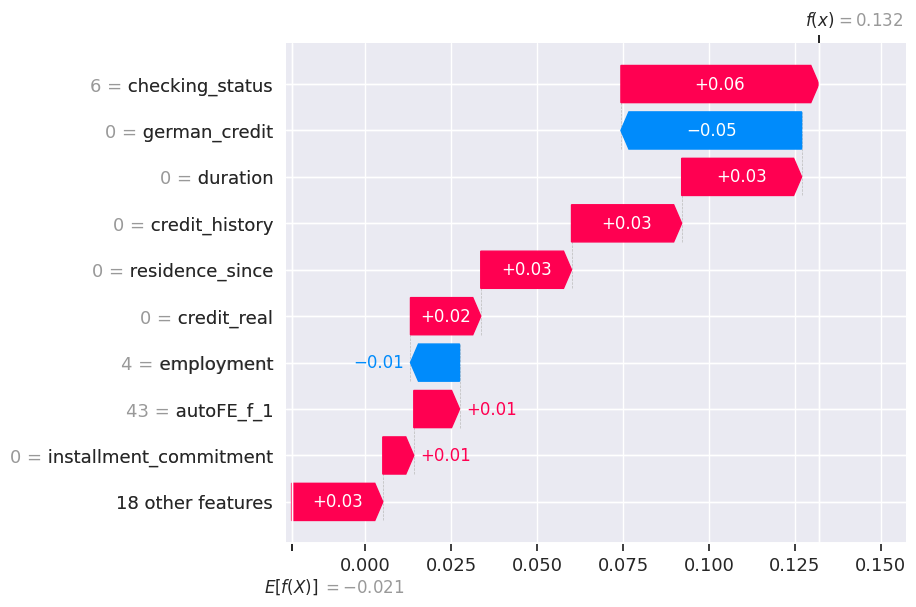

In [16]:
# 模型可解释性-单样本中特征对label的影响
shap.plots.waterfall(shap_values[0])

#### 模型可解释性-多样本中特征对label的影响

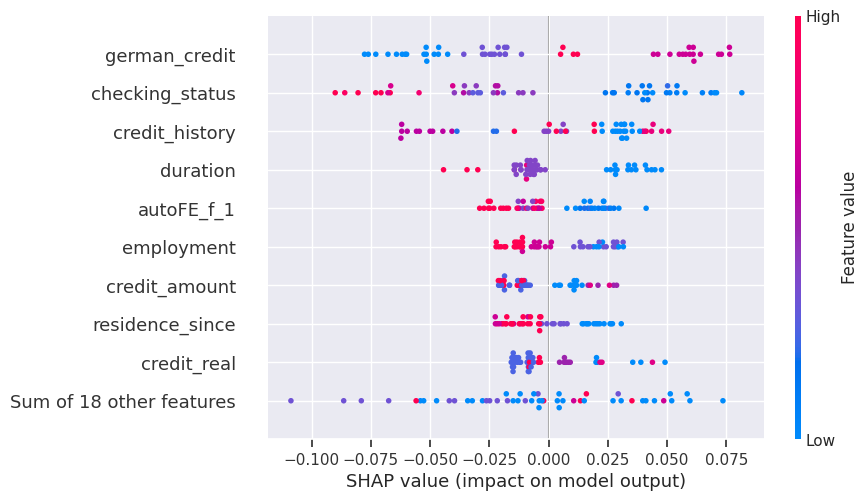

In [17]:
# 模型可解释性-多样本中特征对label的影响
shap.plots.beeswarm(shap_values[:50])

#### 模型可解释性-特征重要性

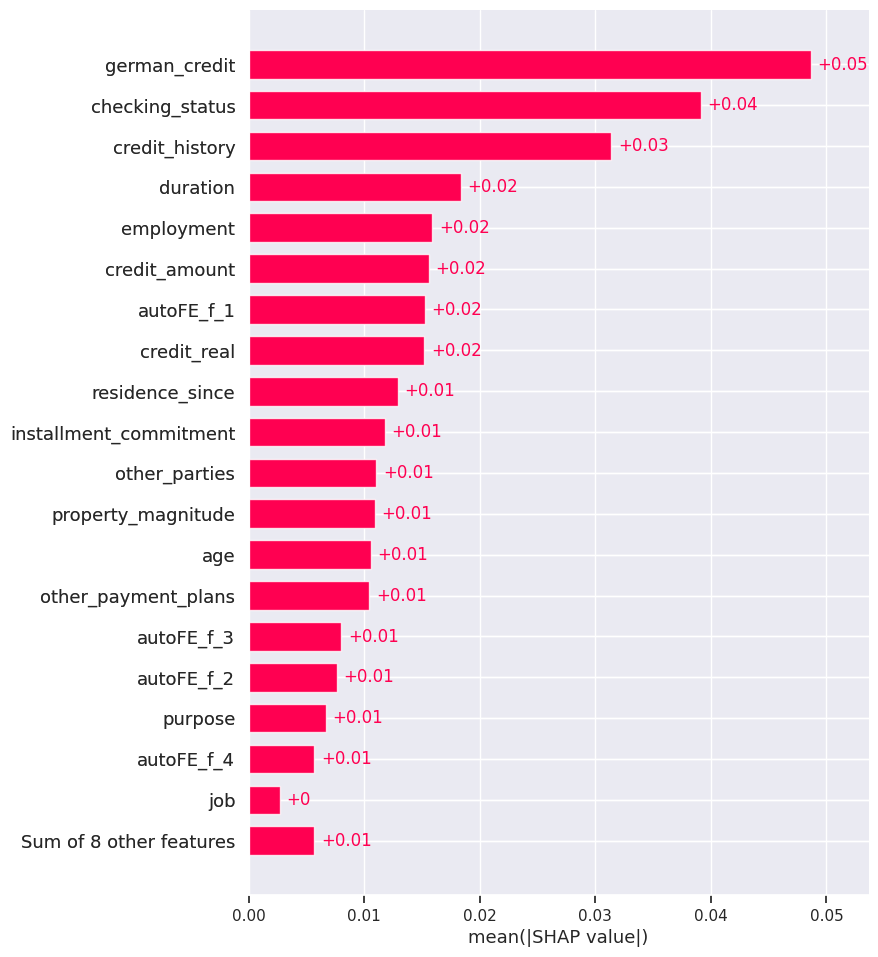

In [18]:
# 模型可解释性-特征重要性
shap.plots.bar(shap_values, max_display=20)